In [1]:
# !rm -rf /kaggle/working/handwriting-generator-model
# !git clone https://github.com/Shambu-K/handwriting-generator-model.git
# !pip install fastdtw
# %cd /kaggle/working/handwriting-generator-model/Code/STR_model

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
from model import STR_Model, STR_Model_Longer_512, STR_Model_Longer_1024
from dataset.iam_dataloader import HandwritingDataset
from loss.stroke_loss import STR_Loss
from util.visualize_progress import visualize_progress, plot_losses
from fastdtw import fastdtw
from tqdm.notebook import tqdm
import os

In [3]:
def train(model, train_loader, loss_function, optimizer, device, epoch=0):
    # Setting the model to training mode
    model.train() 
    length = len(train_loader)
    # Looping over each batch from the training set 
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch}', total=length, disable=True):  
        # data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  
        output = model(data)  
        loss = loss_function(output, target) 
        loss.backward()
        # Updating the model parameters
        optimizer.step() 

        if batch_idx % 100 == 0:
            print(f'   Batch: {batch_idx:<4} | Width: {data.shape[-1]:<3} | Loss: {loss.item():.4f}')
            
    return loss.item()

def model_fit(model, train_loader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint, plot=100):
    train_losses = []
    for epoch in tqdm(range(num_epochs)):
        if epoch % plot == 0: 
            visualize_progress(model, device, train_loader, epoch)
            print('=====================================================================\n')
        loss = train(model, train_loader, loss_function, optimizer, device, epoch+1)
        train_losses.append(loss)
        scheduler.step()
        if epoch % checkpoint == 0:
            model_file = f'./checkpoints/{model.__class__.__name__}_{epoch}_{int(loss)}.pth'
            torch.save(model.state_dict(), model_file) 
    
    return train_losses

# Util functions
def set_best_model(model, checkpoint_dir):
    ''' Set the model with least loss as the best model. '''
    best_loss = 100000
    best_model = None
    for file in os.listdir(checkpoint_dir):
        if file.endswith('.pth') and file.startswith(model.__class__.__name__):
            loss = int(file.split('_')[-1].split('.')[0])
            if loss < best_loss:
                best_loss = loss
                best_model = file
    if best_model is not None:
        model.load_state_dict(torch.load(os.path.join(checkpoint_dir, best_model)))
        print(f'Best model: {best_model}')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Training parameters
num_epochs = 10000
batch_size = 16 # Archibald it is 32
checkpoint_interval = 1000
learning_rate = 0.0001
lr_decay = 1

print('Using device:', device)

Using device: cuda


In [5]:
# Load data
# root_dir = '/kaggle/input/iam-dataset-online/Resized_Dataset/Train'
root_dir = '../../DataSet/IAM-Online/Resized_Dataset/Train/'
dataset = HandwritingDataset(root_dir, batch_size, device, max_allowed_width=400)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

Preprocessing data: 100%|██████████| 2649/2649 [00:32<00:00, 80.63it/s] 


In [ ]:
# For singluar image
# idx = 1555
# dataloader = [(dataset[idx][0].unsqueeze(0), dataset[idx][1].unsqueeze(0))]

In [6]:
# Model
model = STR_Model_Longer_512().to(device)
set_best_model(model, './checkpoints/')
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)
loss_function = STR_Loss(sos_weight=5)

Image id: 29247


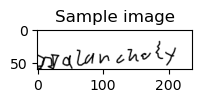

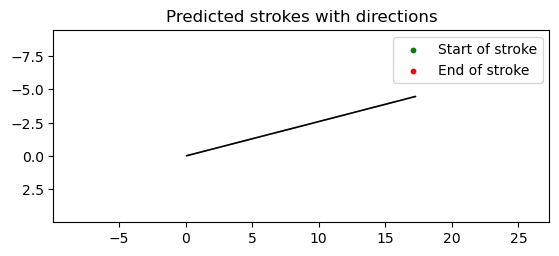

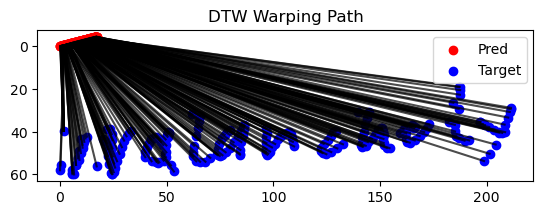

Epoch 1:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 526.2290
   Batch: 100  | Width: 46  | Loss: 354.2464
   Batch: 200  | Width: 56  | Loss: 333.2035
   Batch: 300  | Width: 64  | Loss: 282.0140
   Batch: 400  | Width: 72  | Loss: 300.1054
   Batch: 500  | Width: 78  | Loss: 296.2649
   Batch: 600  | Width: 84  | Loss: 294.4721
   Batch: 700  | Width: 90  | Loss: 390.8161
   Batch: 800  | Width: 96  | Loss: 358.8040
   Batch: 900  | Width: 102 | Loss: 392.6435
   Batch: 1000 | Width: 108 | Loss: 353.8258
   Batch: 1100 | Width: 114 | Loss: 378.8428
   Batch: 1200 | Width: 120 | Loss: 435.9533
   Batch: 1300 | Width: 126 | Loss: 436.0413
   Batch: 1400 | Width: 134 | Loss: 429.8477
   Batch: 1500 | Width: 140 | Loss: 399.3956
   Batch: 1600 | Width: 148 | Loss: 421.8497
   Batch: 1700 | Width: 156 | Loss: 392.9611
   Batch: 1800 | Width: 166 | Loss: 541.7748
   Batch: 1900 | Width: 176 | Loss: 532.3318
   Batch: 2000 | Width: 188 | Loss: 516.5742
   Batch: 2100 | Width: 200 | Loss: 573.9084
   Batch: 

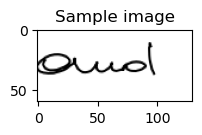

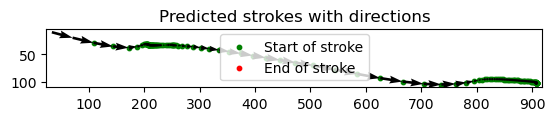

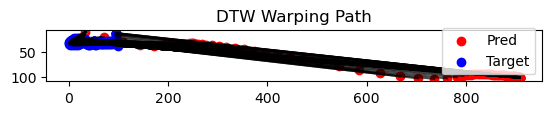

Epoch 2:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 617.0953
   Batch: 100  | Width: 46  | Loss: 310.0864
   Batch: 200  | Width: 56  | Loss: 273.5143
   Batch: 300  | Width: 64  | Loss: 273.5082
   Batch: 400  | Width: 72  | Loss: 252.3318
   Batch: 500  | Width: 78  | Loss: 262.1764
   Batch: 600  | Width: 84  | Loss: 258.5874
   Batch: 700  | Width: 90  | Loss: 306.6062
   Batch: 800  | Width: 96  | Loss: 277.8083
   Batch: 900  | Width: 102 | Loss: 336.1069
   Batch: 1000 | Width: 108 | Loss: 354.3047
   Batch: 1100 | Width: 114 | Loss: 325.5547
   Batch: 1200 | Width: 120 | Loss: 343.4001
   Batch: 1300 | Width: 126 | Loss: 367.9312
   Batch: 1400 | Width: 134 | Loss: 385.3439
   Batch: 1500 | Width: 140 | Loss: 345.4383
   Batch: 1600 | Width: 148 | Loss: 405.8393
   Batch: 1700 | Width: 156 | Loss: 388.3052
   Batch: 1800 | Width: 166 | Loss: 502.6184
   Batch: 1900 | Width: 176 | Loss: 458.4581
   Batch: 2000 | Width: 188 | Loss: 438.7045
   Batch: 2100 | Width: 200 | Loss: 478.0180
   Batch: 

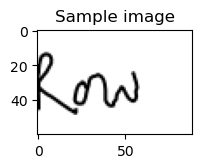

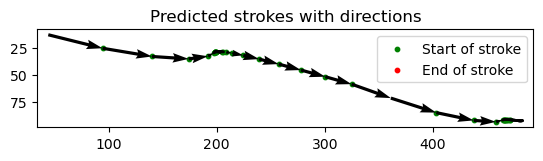

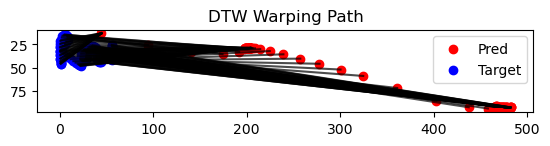

Epoch 3:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 560.3525
   Batch: 100  | Width: 46  | Loss: 274.2442
   Batch: 200  | Width: 56  | Loss: 275.7258
   Batch: 300  | Width: 64  | Loss: 291.7501
   Batch: 400  | Width: 72  | Loss: 254.6322
   Batch: 500  | Width: 78  | Loss: 269.7275
   Batch: 600  | Width: 84  | Loss: 263.4951
   Batch: 700  | Width: 90  | Loss: 322.5166
   Batch: 800  | Width: 96  | Loss: 304.9610
   Batch: 900  | Width: 102 | Loss: 334.4795
   Batch: 1000 | Width: 108 | Loss: 333.6601
   Batch: 1100 | Width: 114 | Loss: 284.8483
   Batch: 1200 | Width: 120 | Loss: 342.0798
   Batch: 1300 | Width: 126 | Loss: 385.1612
   Batch: 1400 | Width: 134 | Loss: 381.6713
   Batch: 1500 | Width: 140 | Loss: 389.6027
   Batch: 1600 | Width: 148 | Loss: 421.9288
   Batch: 1700 | Width: 156 | Loss: 395.0026
   Batch: 1800 | Width: 166 | Loss: 505.7723
   Batch: 1900 | Width: 176 | Loss: 434.7457
   Batch: 2000 | Width: 188 | Loss: 428.3660
   Batch: 2100 | Width: 200 | Loss: 474.6145
   Batch: 

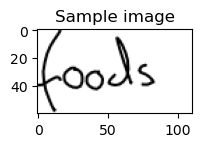

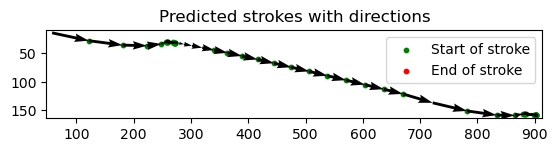

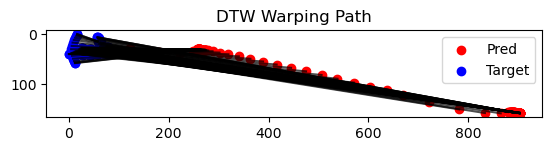

Epoch 4:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 588.4087
   Batch: 100  | Width: 46  | Loss: 270.0974
   Batch: 200  | Width: 56  | Loss: 276.3701
   Batch: 300  | Width: 64  | Loss: 261.7627
   Batch: 400  | Width: 72  | Loss: 257.3400
   Batch: 500  | Width: 78  | Loss: 242.0399
   Batch: 600  | Width: 84  | Loss: 251.1778
   Batch: 700  | Width: 90  | Loss: 299.9787
   Batch: 800  | Width: 96  | Loss: 265.9532
   Batch: 900  | Width: 102 | Loss: 319.9351
   Batch: 1000 | Width: 108 | Loss: 312.8358
   Batch: 1100 | Width: 114 | Loss: 272.6006
   Batch: 1200 | Width: 120 | Loss: 349.8881
   Batch: 1300 | Width: 126 | Loss: 371.8768
   Batch: 1400 | Width: 134 | Loss: 380.9361
   Batch: 1500 | Width: 140 | Loss: 331.2093
   Batch: 1600 | Width: 148 | Loss: 442.6865
   Batch: 1700 | Width: 156 | Loss: 406.5045
   Batch: 1800 | Width: 166 | Loss: 495.2377
   Batch: 1900 | Width: 176 | Loss: 428.3341
   Batch: 2000 | Width: 188 | Loss: 528.9716
   Batch: 2100 | Width: 200 | Loss: 536.6290
   Batch: 

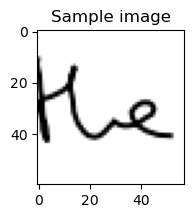

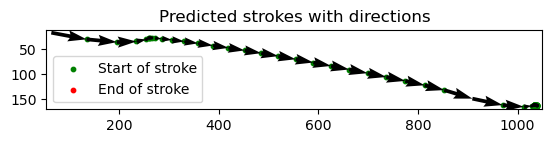

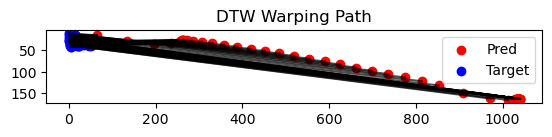

Epoch 5:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 510.0404
   Batch: 100  | Width: 46  | Loss: 297.0239
   Batch: 200  | Width: 56  | Loss: 262.5418
   Batch: 300  | Width: 64  | Loss: 268.9280
   Batch: 400  | Width: 72  | Loss: 229.6487
   Batch: 500  | Width: 78  | Loss: 275.0659
   Batch: 600  | Width: 84  | Loss: 267.8946
   Batch: 700  | Width: 90  | Loss: 299.5115
   Batch: 800  | Width: 96  | Loss: 241.8641
   Batch: 900  | Width: 102 | Loss: 316.7036
   Batch: 1000 | Width: 108 | Loss: 340.7077
   Batch: 1100 | Width: 114 | Loss: 290.2598
   Batch: 1200 | Width: 120 | Loss: 339.9585
   Batch: 1300 | Width: 126 | Loss: 377.7840
   Batch: 1400 | Width: 134 | Loss: 364.6195
   Batch: 1500 | Width: 140 | Loss: 320.2443
   Batch: 1600 | Width: 148 | Loss: 375.1940
   Batch: 1700 | Width: 156 | Loss: 330.0537
   Batch: 1800 | Width: 166 | Loss: 517.3793
   Batch: 1900 | Width: 176 | Loss: 423.1875
   Batch: 2000 | Width: 188 | Loss: 461.9088
   Batch: 2100 | Width: 200 | Loss: 457.8378
   Batch: 

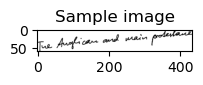

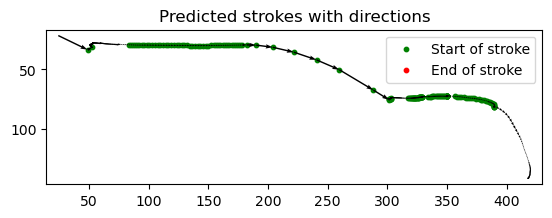

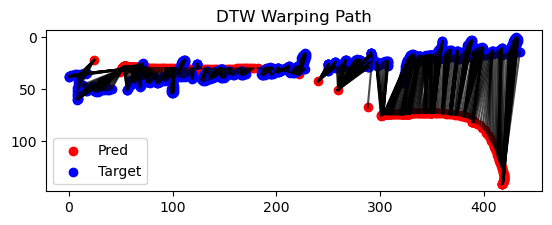

Epoch 6:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 533.6345
   Batch: 100  | Width: 46  | Loss: 252.3921
   Batch: 200  | Width: 56  | Loss: 288.8332
   Batch: 300  | Width: 64  | Loss: 286.1036
   Batch: 400  | Width: 72  | Loss: 245.8878
   Batch: 500  | Width: 78  | Loss: 256.2394
   Batch: 600  | Width: 84  | Loss: 253.1615
   Batch: 700  | Width: 90  | Loss: 315.3775
   Batch: 800  | Width: 96  | Loss: 267.8927
   Batch: 900  | Width: 102 | Loss: 307.0617
   Batch: 1000 | Width: 108 | Loss: 333.5271
   Batch: 1100 | Width: 114 | Loss: 281.4075
   Batch: 1200 | Width: 120 | Loss: 331.2135
   Batch: 1300 | Width: 126 | Loss: 367.3255
   Batch: 1400 | Width: 134 | Loss: 370.3342
   Batch: 1500 | Width: 140 | Loss: 373.7124
   Batch: 1600 | Width: 148 | Loss: 377.1187
   Batch: 1700 | Width: 156 | Loss: 391.9281
   Batch: 1800 | Width: 166 | Loss: 499.0350
   Batch: 1900 | Width: 176 | Loss: 428.4948
   Batch: 2000 | Width: 188 | Loss: 443.1061
   Batch: 2100 | Width: 200 | Loss: 446.9191
   Batch: 

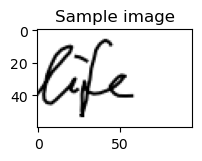

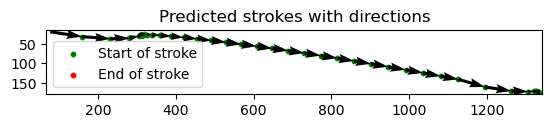

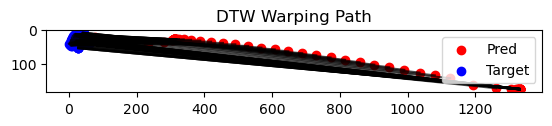

Epoch 7:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 510.0479
   Batch: 100  | Width: 46  | Loss: 269.5276
   Batch: 200  | Width: 56  | Loss: 260.5878
   Batch: 300  | Width: 64  | Loss: 259.7795
   Batch: 400  | Width: 72  | Loss: 241.5590
   Batch: 500  | Width: 78  | Loss: 264.0645
   Batch: 600  | Width: 84  | Loss: 264.5824
   Batch: 700  | Width: 90  | Loss: 288.4611
   Batch: 800  | Width: 96  | Loss: 243.5739
   Batch: 900  | Width: 102 | Loss: 334.8602
   Batch: 1000 | Width: 108 | Loss: 333.9826
   Batch: 1100 | Width: 114 | Loss: 315.2798
   Batch: 1200 | Width: 120 | Loss: 318.8375
   Batch: 1300 | Width: 126 | Loss: 366.2804
   Batch: 1400 | Width: 134 | Loss: 391.7569
   Batch: 1500 | Width: 140 | Loss: 337.8844
   Batch: 1600 | Width: 148 | Loss: 386.1481
   Batch: 1700 | Width: 156 | Loss: 331.7173
   Batch: 1800 | Width: 166 | Loss: 427.9642
   Batch: 1900 | Width: 176 | Loss: 370.8205
   Batch: 2000 | Width: 188 | Loss: 417.4510
   Batch: 2100 | Width: 200 | Loss: 483.7642
   Batch: 

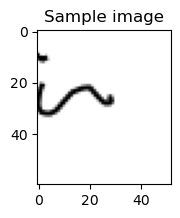

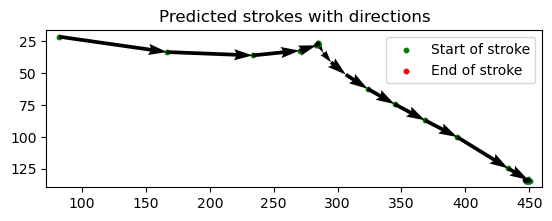

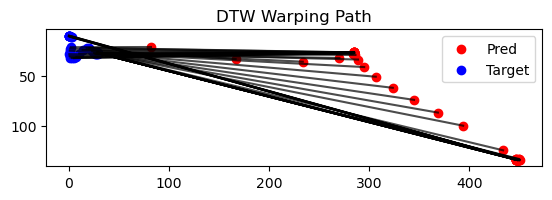

Epoch 8:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 505.8499
   Batch: 100  | Width: 46  | Loss: 253.9311
   Batch: 200  | Width: 56  | Loss: 253.9392
   Batch: 300  | Width: 64  | Loss: 307.7429
   Batch: 400  | Width: 72  | Loss: 243.7807
   Batch: 500  | Width: 78  | Loss: 285.8617
   Batch: 600  | Width: 84  | Loss: 256.1736
   Batch: 700  | Width: 90  | Loss: 276.3918
   Batch: 800  | Width: 96  | Loss: 227.3614
   Batch: 900  | Width: 102 | Loss: 304.9231
   Batch: 1000 | Width: 108 | Loss: 292.4806
   Batch: 1100 | Width: 114 | Loss: 302.7350
   Batch: 1200 | Width: 120 | Loss: 326.5863
   Batch: 1300 | Width: 126 | Loss: 348.0453
   Batch: 1400 | Width: 134 | Loss: 354.1237
   Batch: 1500 | Width: 140 | Loss: 379.3424
   Batch: 1600 | Width: 148 | Loss: 389.3152
   Batch: 1700 | Width: 156 | Loss: 380.0570
   Batch: 1800 | Width: 166 | Loss: 508.9696
   Batch: 1900 | Width: 176 | Loss: 423.6438
   Batch: 2000 | Width: 188 | Loss: 493.9122
   Batch: 2100 | Width: 200 | Loss: 431.9320
   Batch: 

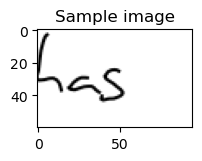

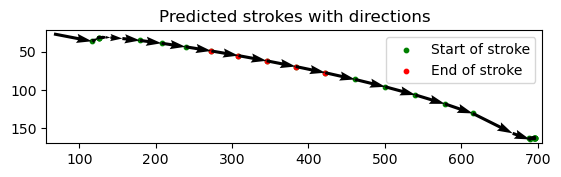

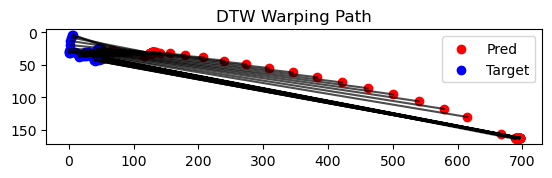

Epoch 9:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 501.2952
   Batch: 100  | Width: 46  | Loss: 260.9341
   Batch: 200  | Width: 56  | Loss: 251.9656
   Batch: 300  | Width: 64  | Loss: 241.0770
   Batch: 400  | Width: 72  | Loss: 239.2111
   Batch: 500  | Width: 78  | Loss: 264.4937
   Batch: 600  | Width: 84  | Loss: 277.0511
   Batch: 700  | Width: 90  | Loss: 274.9623
   Batch: 800  | Width: 96  | Loss: 245.2240
   Batch: 900  | Width: 102 | Loss: 319.0036
   Batch: 1000 | Width: 108 | Loss: 328.8995
   Batch: 1100 | Width: 114 | Loss: 306.5183
   Batch: 1200 | Width: 120 | Loss: 308.3129
   Batch: 1300 | Width: 126 | Loss: 347.8937
   Batch: 1400 | Width: 134 | Loss: 405.6537
   Batch: 1500 | Width: 140 | Loss: 327.1132
   Batch: 1600 | Width: 148 | Loss: 362.7704
   Batch: 1700 | Width: 156 | Loss: 439.1538
   Batch: 1800 | Width: 166 | Loss: 441.7971
   Batch: 1900 | Width: 176 | Loss: 369.0883
   Batch: 2000 | Width: 188 | Loss: 378.3543
   Batch: 2100 | Width: 200 | Loss: 415.3631
   Batch: 

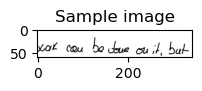

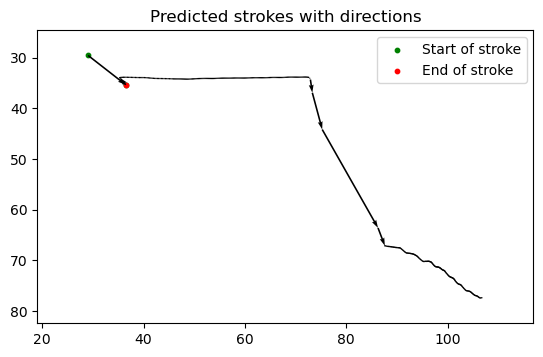

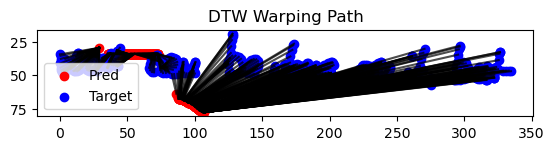

Epoch 10:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 469.7052
   Batch: 100  | Width: 46  | Loss: 245.1591
   Batch: 200  | Width: 56  | Loss: 266.7169
   Batch: 300  | Width: 64  | Loss: 249.1985
   Batch: 400  | Width: 72  | Loss: 214.0896
   Batch: 500  | Width: 78  | Loss: 264.5715
   Batch: 600  | Width: 84  | Loss: 279.2697
   Batch: 700  | Width: 90  | Loss: 260.6965
   Batch: 800  | Width: 96  | Loss: 245.5129
   Batch: 900  | Width: 102 | Loss: 314.8300
   Batch: 1000 | Width: 108 | Loss: 316.3991
   Batch: 1100 | Width: 114 | Loss: 285.8301
   Batch: 1200 | Width: 120 | Loss: 294.0918
   Batch: 1300 | Width: 126 | Loss: 357.4458
   Batch: 1400 | Width: 134 | Loss: 338.6437
   Batch: 1500 | Width: 140 | Loss: 330.1857
   Batch: 1600 | Width: 148 | Loss: 404.0570
   Batch: 1700 | Width: 156 | Loss: 322.3695
   Batch: 1800 | Width: 166 | Loss: 418.0666
   Batch: 1900 | Width: 176 | Loss: 399.1699
   Batch: 2000 | Width: 188 | Loss: 387.4589
   Batch: 2100 | Width: 200 | Loss: 426.4493
   Batch: 

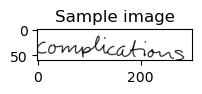

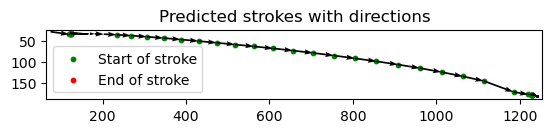

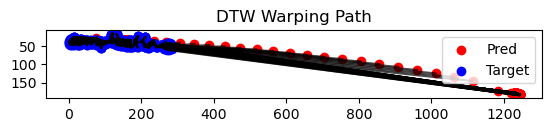

Epoch 11:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 447.9934
   Batch: 100  | Width: 46  | Loss: 250.0934
   Batch: 200  | Width: 56  | Loss: 272.0365
   Batch: 300  | Width: 64  | Loss: 240.1922
   Batch: 400  | Width: 72  | Loss: 220.7585
   Batch: 500  | Width: 78  | Loss: 253.1753
   Batch: 600  | Width: 84  | Loss: 282.1447
   Batch: 700  | Width: 90  | Loss: 275.7314
   Batch: 800  | Width: 96  | Loss: 232.0780
   Batch: 900  | Width: 102 | Loss: 326.5512
   Batch: 1000 | Width: 108 | Loss: 312.0479
   Batch: 1100 | Width: 114 | Loss: 309.5123
   Batch: 1200 | Width: 120 | Loss: 317.9701
   Batch: 1300 | Width: 126 | Loss: 357.1275
   Batch: 1400 | Width: 134 | Loss: 347.8508
   Batch: 1500 | Width: 140 | Loss: 352.9431
   Batch: 1600 | Width: 148 | Loss: 379.8632
   Batch: 1700 | Width: 156 | Loss: 326.2098
   Batch: 1800 | Width: 166 | Loss: 485.8658
   Batch: 1900 | Width: 176 | Loss: 364.5419
   Batch: 2000 | Width: 188 | Loss: 500.2873
   Batch: 2100 | Width: 200 | Loss: 447.5235
   Batch: 

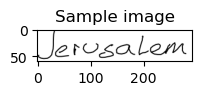

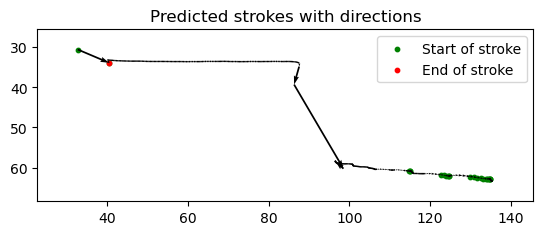

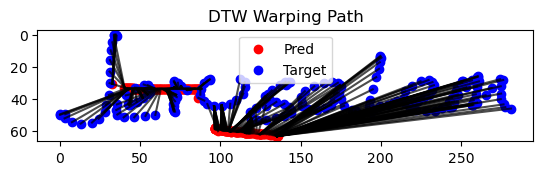

Epoch 12:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 419.2800
   Batch: 100  | Width: 46  | Loss: 239.8703
   Batch: 200  | Width: 56  | Loss: 281.1996
   Batch: 300  | Width: 64  | Loss: 272.1053
   Batch: 400  | Width: 72  | Loss: 232.6271
   Batch: 500  | Width: 78  | Loss: 271.4153
   Batch: 600  | Width: 84  | Loss: 268.0303
   Batch: 700  | Width: 90  | Loss: 260.5188
   Batch: 800  | Width: 96  | Loss: 269.1454
   Batch: 900  | Width: 102 | Loss: 325.0073
   Batch: 1000 | Width: 108 | Loss: 304.2063
   Batch: 1100 | Width: 114 | Loss: 298.5173
   Batch: 1200 | Width: 120 | Loss: 294.8529
   Batch: 1300 | Width: 126 | Loss: 355.9796
   Batch: 1400 | Width: 134 | Loss: 374.3322
   Batch: 1500 | Width: 140 | Loss: 358.0588
   Batch: 1600 | Width: 148 | Loss: 352.5974
   Batch: 1700 | Width: 156 | Loss: 336.3007
   Batch: 1800 | Width: 166 | Loss: 432.2931
   Batch: 1900 | Width: 176 | Loss: 413.1239
   Batch: 2000 | Width: 188 | Loss: 503.0985
   Batch: 2100 | Width: 200 | Loss: 426.5255
   Batch: 

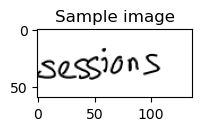

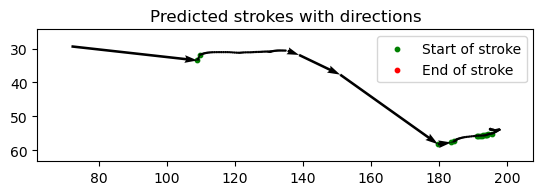

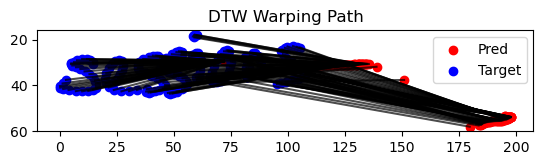

Epoch 13:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 399.7801
   Batch: 100  | Width: 46  | Loss: 247.1983
   Batch: 200  | Width: 56  | Loss: 267.3465
   Batch: 300  | Width: 64  | Loss: 254.3656
   Batch: 400  | Width: 72  | Loss: 247.7779
   Batch: 500  | Width: 78  | Loss: 253.4677
   Batch: 600  | Width: 84  | Loss: 281.2621
   Batch: 700  | Width: 90  | Loss: 276.8644
   Batch: 800  | Width: 96  | Loss: 231.4521
   Batch: 900  | Width: 102 | Loss: 279.3441
   Batch: 1000 | Width: 108 | Loss: 320.1259
   Batch: 1100 | Width: 114 | Loss: 313.4346
   Batch: 1200 | Width: 120 | Loss: 288.4442
   Batch: 1300 | Width: 126 | Loss: 354.0830
   Batch: 1400 | Width: 134 | Loss: 368.9875
   Batch: 1500 | Width: 140 | Loss: 406.4628
   Batch: 1600 | Width: 148 | Loss: 385.8912
   Batch: 1700 | Width: 156 | Loss: 414.9529
   Batch: 1800 | Width: 166 | Loss: 454.7883
   Batch: 1900 | Width: 176 | Loss: 419.5372
   Batch: 2000 | Width: 188 | Loss: 486.9680
   Batch: 2100 | Width: 200 | Loss: 427.1937
   Batch: 

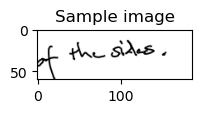

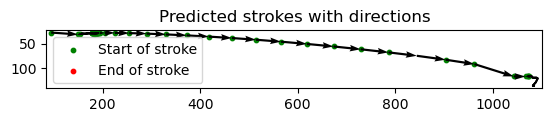

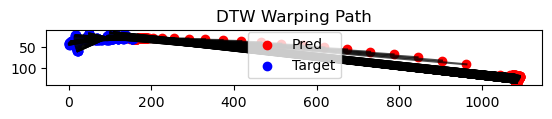

Epoch 14:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 388.6824
   Batch: 100  | Width: 46  | Loss: 238.7877
   Batch: 200  | Width: 56  | Loss: 277.7209
   Batch: 300  | Width: 64  | Loss: 249.5811
   Batch: 400  | Width: 72  | Loss: 256.7404
   Batch: 500  | Width: 78  | Loss: 240.0153
   Batch: 600  | Width: 84  | Loss: 305.0922
   Batch: 700  | Width: 90  | Loss: 280.5129
   Batch: 800  | Width: 96  | Loss: 262.6905
   Batch: 900  | Width: 102 | Loss: 287.4246
   Batch: 1000 | Width: 108 | Loss: 306.1567
   Batch: 1100 | Width: 114 | Loss: 289.6468
   Batch: 1200 | Width: 120 | Loss: 307.9230
   Batch: 1300 | Width: 126 | Loss: 310.1064
   Batch: 1400 | Width: 134 | Loss: 345.1003
   Batch: 1500 | Width: 140 | Loss: 345.6628
   Batch: 1600 | Width: 148 | Loss: 417.4871
   Batch: 1700 | Width: 156 | Loss: 330.2411
   Batch: 1800 | Width: 166 | Loss: 456.4360
   Batch: 1900 | Width: 176 | Loss: 385.9473
   Batch: 2000 | Width: 188 | Loss: 455.2097
   Batch: 2100 | Width: 200 | Loss: 402.9739
   Batch: 

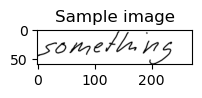

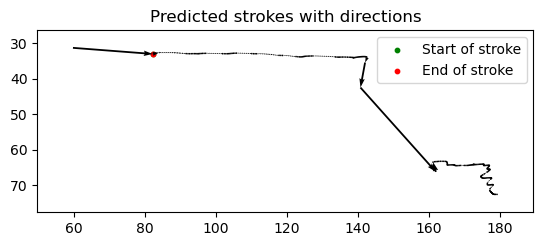

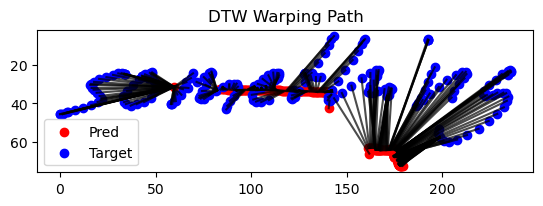

Epoch 15:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 344.7398
   Batch: 100  | Width: 46  | Loss: 256.2833
   Batch: 200  | Width: 56  | Loss: 306.8977
   Batch: 300  | Width: 64  | Loss: 252.3603
   Batch: 400  | Width: 72  | Loss: 232.5237
   Batch: 500  | Width: 78  | Loss: 306.8911
   Batch: 600  | Width: 84  | Loss: 301.4156
   Batch: 700  | Width: 90  | Loss: 283.0367
   Batch: 800  | Width: 96  | Loss: 243.6094
   Batch: 900  | Width: 102 | Loss: 310.4871
   Batch: 1000 | Width: 108 | Loss: 322.9868
   Batch: 1100 | Width: 114 | Loss: 310.5903
   Batch: 1200 | Width: 120 | Loss: 297.1963
   Batch: 1300 | Width: 126 | Loss: 367.3809
   Batch: 1400 | Width: 134 | Loss: 356.8957
   Batch: 1500 | Width: 140 | Loss: 340.2356
   Batch: 1600 | Width: 148 | Loss: 367.7348
   Batch: 1700 | Width: 156 | Loss: 332.0200
   Batch: 1800 | Width: 166 | Loss: 409.6835
   Batch: 1900 | Width: 176 | Loss: 361.3514
   Batch: 2000 | Width: 188 | Loss: 432.4897
   Batch: 2100 | Width: 200 | Loss: 439.7800
   Batch: 

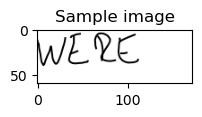

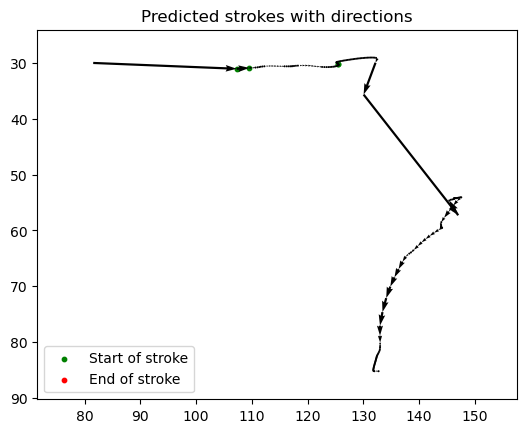

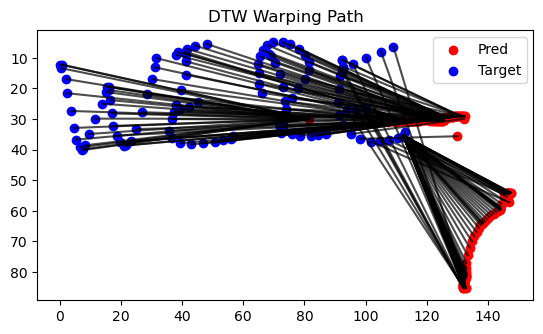

Epoch 16:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 307.6958
   Batch: 100  | Width: 46  | Loss: 259.6332
   Batch: 200  | Width: 56  | Loss: 258.0159
   Batch: 300  | Width: 64  | Loss: 233.8643
   Batch: 400  | Width: 72  | Loss: 223.2024
   Batch: 500  | Width: 78  | Loss: 238.7066
   Batch: 600  | Width: 84  | Loss: 275.8816
   Batch: 700  | Width: 90  | Loss: 273.3449
   Batch: 800  | Width: 96  | Loss: 276.1286
   Batch: 900  | Width: 102 | Loss: 284.1086
   Batch: 1000 | Width: 108 | Loss: 317.0610
   Batch: 1100 | Width: 114 | Loss: 297.7822
   Batch: 1200 | Width: 120 | Loss: 288.5215
   Batch: 1300 | Width: 126 | Loss: 389.7228
   Batch: 1400 | Width: 134 | Loss: 355.7400
   Batch: 1500 | Width: 140 | Loss: 322.8591
   Batch: 1600 | Width: 148 | Loss: 404.1011
   Batch: 1700 | Width: 156 | Loss: 342.3318
   Batch: 1800 | Width: 166 | Loss: 490.5237
   Batch: 1900 | Width: 176 | Loss: 409.8864
   Batch: 2000 | Width: 188 | Loss: 487.7088
   Batch: 2100 | Width: 200 | Loss: 408.0627
   Batch: 

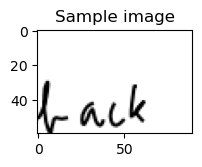

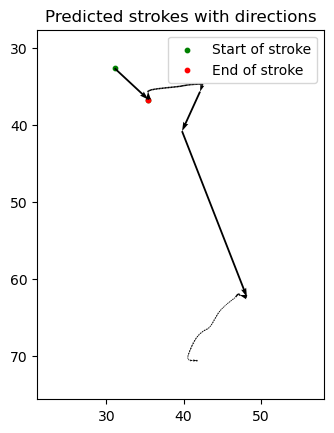

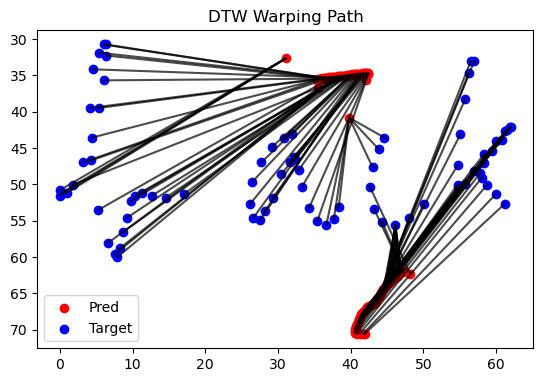

Epoch 17:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 270.3513
   Batch: 100  | Width: 46  | Loss: 256.8884
   Batch: 200  | Width: 56  | Loss: 281.5853
   Batch: 300  | Width: 64  | Loss: 241.6538
   Batch: 400  | Width: 72  | Loss: 225.7492
   Batch: 500  | Width: 78  | Loss: 277.4969
   Batch: 600  | Width: 84  | Loss: 291.4409
   Batch: 700  | Width: 90  | Loss: 247.9839
   Batch: 800  | Width: 96  | Loss: 245.4844
   Batch: 900  | Width: 102 | Loss: 312.3628
   Batch: 1000 | Width: 108 | Loss: 329.0720
   Batch: 1100 | Width: 114 | Loss: 324.8653
   Batch: 1200 | Width: 120 | Loss: 283.8207
   Batch: 1300 | Width: 126 | Loss: 349.9629
   Batch: 1400 | Width: 134 | Loss: 384.4559
   Batch: 1500 | Width: 140 | Loss: 337.8786
   Batch: 1600 | Width: 148 | Loss: 417.5313
   Batch: 1700 | Width: 156 | Loss: 363.4468
   Batch: 1800 | Width: 166 | Loss: 426.9408
   Batch: 1900 | Width: 176 | Loss: 397.7002
   Batch: 2000 | Width: 188 | Loss: 458.6602
   Batch: 2100 | Width: 200 | Loss: 431.3844
   Batch: 

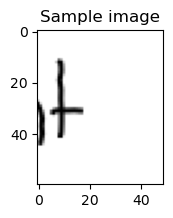

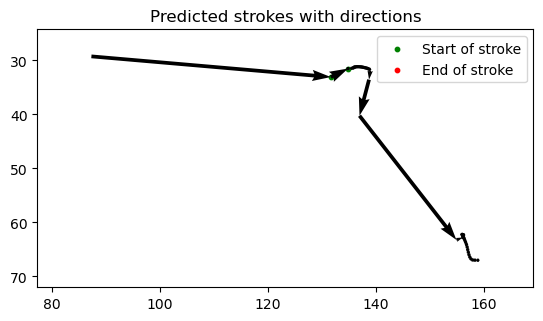

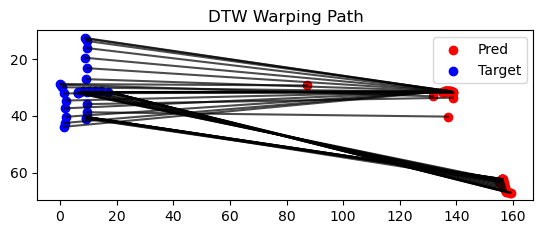

Epoch 18:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 271.3445
   Batch: 100  | Width: 46  | Loss: 265.1194
   Batch: 200  | Width: 56  | Loss: 268.6708
   Batch: 300  | Width: 64  | Loss: 241.6106
   Batch: 400  | Width: 72  | Loss: 232.4562
   Batch: 500  | Width: 78  | Loss: 278.9475
   Batch: 600  | Width: 84  | Loss: 262.6520
   Batch: 700  | Width: 90  | Loss: 271.1210
   Batch: 800  | Width: 96  | Loss: 224.9443
   Batch: 900  | Width: 102 | Loss: 303.4067
   Batch: 1000 | Width: 108 | Loss: 315.1950
   Batch: 1100 | Width: 114 | Loss: 317.1575
   Batch: 1200 | Width: 120 | Loss: 286.4593
   Batch: 1300 | Width: 126 | Loss: 410.9781
   Batch: 1400 | Width: 134 | Loss: 355.4040
   Batch: 1500 | Width: 140 | Loss: 351.9011
   Batch: 1600 | Width: 148 | Loss: 417.9095
   Batch: 1700 | Width: 156 | Loss: 358.5301
   Batch: 1800 | Width: 166 | Loss: 450.3515
   Batch: 1900 | Width: 176 | Loss: 381.2614
   Batch: 2000 | Width: 188 | Loss: 371.6759
   Batch: 2100 | Width: 200 | Loss: 427.1295
   Batch: 

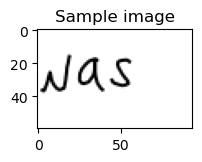

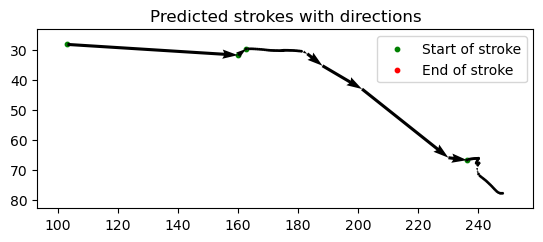

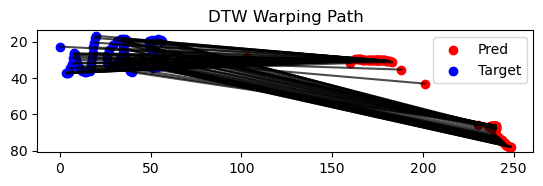

Epoch 19:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 256.4156
   Batch: 100  | Width: 46  | Loss: 240.8728
   Batch: 200  | Width: 56  | Loss: 246.6980
   Batch: 300  | Width: 64  | Loss: 240.4606
   Batch: 400  | Width: 72  | Loss: 236.7476
   Batch: 500  | Width: 78  | Loss: 250.1143
   Batch: 600  | Width: 84  | Loss: 258.9397
   Batch: 700  | Width: 90  | Loss: 261.7652
   Batch: 800  | Width: 96  | Loss: 247.5148
   Batch: 900  | Width: 102 | Loss: 277.4378
   Batch: 1000 | Width: 108 | Loss: 295.9316
   Batch: 1100 | Width: 114 | Loss: 296.4274
   Batch: 1200 | Width: 120 | Loss: 294.5693
   Batch: 1300 | Width: 126 | Loss: 350.5849
   Batch: 1400 | Width: 134 | Loss: 363.6233
   Batch: 1500 | Width: 140 | Loss: 295.1917
   Batch: 1600 | Width: 148 | Loss: 410.9176
   Batch: 1700 | Width: 156 | Loss: 349.2290
   Batch: 1800 | Width: 166 | Loss: 437.2096
   Batch: 1900 | Width: 176 | Loss: 397.7144
   Batch: 2000 | Width: 188 | Loss: 457.0967
   Batch: 2100 | Width: 200 | Loss: 398.8880
   Batch: 

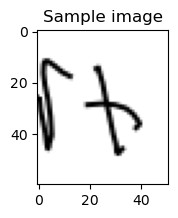

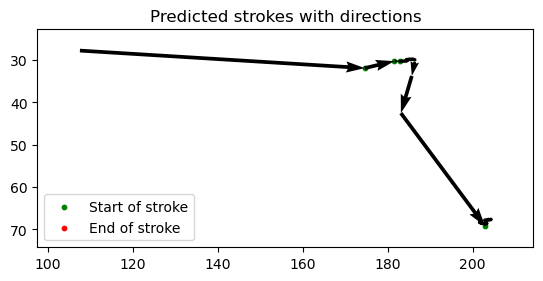

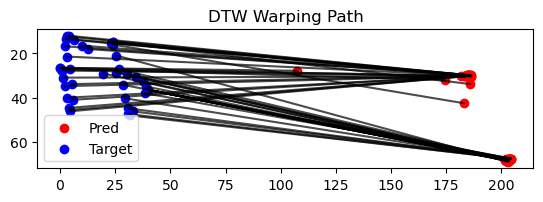

Epoch 20:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 266.9917
   Batch: 100  | Width: 46  | Loss: 272.2852
   Batch: 200  | Width: 56  | Loss: 294.6965
   Batch: 300  | Width: 64  | Loss: 239.3922
   Batch: 400  | Width: 72  | Loss: 221.9160
   Batch: 500  | Width: 78  | Loss: 300.4225
   Batch: 600  | Width: 84  | Loss: 255.8148
   Batch: 700  | Width: 90  | Loss: 234.6403
   Batch: 800  | Width: 96  | Loss: 231.9294
   Batch: 900  | Width: 102 | Loss: 291.0877
   Batch: 1000 | Width: 108 | Loss: 305.0195
   Batch: 1100 | Width: 114 | Loss: 315.1197
   Batch: 1200 | Width: 120 | Loss: 286.3779
   Batch: 1300 | Width: 126 | Loss: 355.0731
   Batch: 1400 | Width: 134 | Loss: 337.1019
   Batch: 1500 | Width: 140 | Loss: 302.2579
   Batch: 1600 | Width: 148 | Loss: 447.3650
   Batch: 1700 | Width: 156 | Loss: 376.1038
   Batch: 1800 | Width: 166 | Loss: 474.4240
   Batch: 1900 | Width: 176 | Loss: 372.7406
   Batch: 2000 | Width: 188 | Loss: 518.8243
   Batch: 2100 | Width: 200 | Loss: 399.8404
   Batch: 

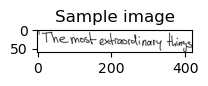

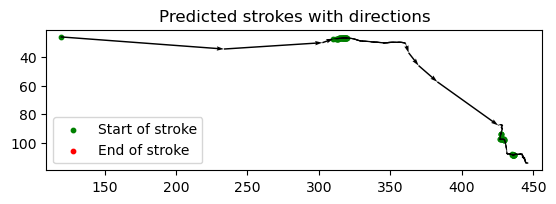

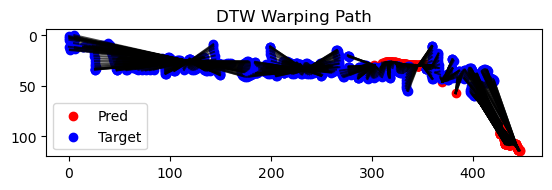

Epoch 21:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 238.5100
   Batch: 100  | Width: 46  | Loss: 248.3904
   Batch: 200  | Width: 56  | Loss: 262.4051
   Batch: 300  | Width: 64  | Loss: 258.1711
   Batch: 400  | Width: 72  | Loss: 231.9230
   Batch: 500  | Width: 78  | Loss: 268.3941
   Batch: 600  | Width: 84  | Loss: 265.1236
   Batch: 700  | Width: 90  | Loss: 259.2562
   Batch: 800  | Width: 96  | Loss: 248.2527
   Batch: 900  | Width: 102 | Loss: 279.5144
   Batch: 1000 | Width: 108 | Loss: 294.1663
   Batch: 1100 | Width: 114 | Loss: 326.7155
   Batch: 1200 | Width: 120 | Loss: 323.7653
   Batch: 1300 | Width: 126 | Loss: 367.1637
   Batch: 1400 | Width: 134 | Loss: 377.2880
   Batch: 1500 | Width: 140 | Loss: 309.8338
   Batch: 1600 | Width: 148 | Loss: 378.2927
   Batch: 1700 | Width: 156 | Loss: 364.6575
   Batch: 1800 | Width: 166 | Loss: 502.1571
   Batch: 1900 | Width: 176 | Loss: 390.3356
   Batch: 2000 | Width: 188 | Loss: 481.8250
   Batch: 2100 | Width: 200 | Loss: 419.8987
   Batch: 

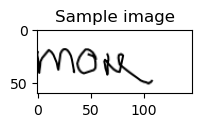

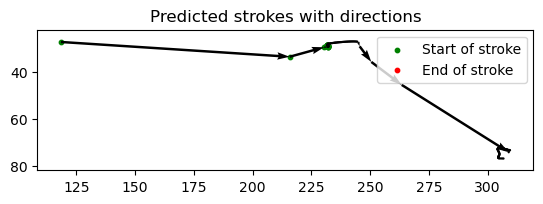

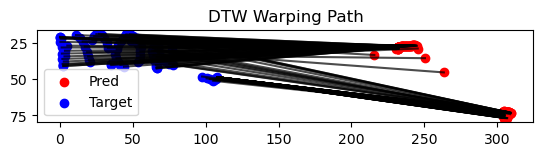

Epoch 22:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 260.6378
   Batch: 100  | Width: 46  | Loss: 241.7027
   Batch: 200  | Width: 56  | Loss: 269.6483
   Batch: 300  | Width: 64  | Loss: 254.3928
   Batch: 400  | Width: 72  | Loss: 245.1094
   Batch: 500  | Width: 78  | Loss: 251.5717
   Batch: 600  | Width: 84  | Loss: 270.6274
   Batch: 700  | Width: 90  | Loss: 254.3010
   Batch: 800  | Width: 96  | Loss: 254.2963
   Batch: 900  | Width: 102 | Loss: 280.6427
   Batch: 1000 | Width: 108 | Loss: 311.1064
   Batch: 1100 | Width: 114 | Loss: 314.5836
   Batch: 1200 | Width: 120 | Loss: 285.8961
   Batch: 1300 | Width: 126 | Loss: 348.6959
   Batch: 1400 | Width: 134 | Loss: 397.5954
   Batch: 1500 | Width: 140 | Loss: 312.4939
   Batch: 1600 | Width: 148 | Loss: 409.9507
   Batch: 1700 | Width: 156 | Loss: 346.7972
   Batch: 1800 | Width: 166 | Loss: 426.8262
   Batch: 1900 | Width: 176 | Loss: 388.2784
   Batch: 2000 | Width: 188 | Loss: 421.0715
   Batch: 2100 | Width: 200 | Loss: 406.3433
   Batch: 

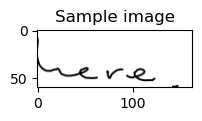

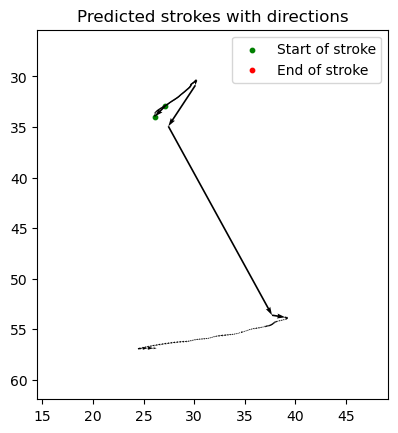

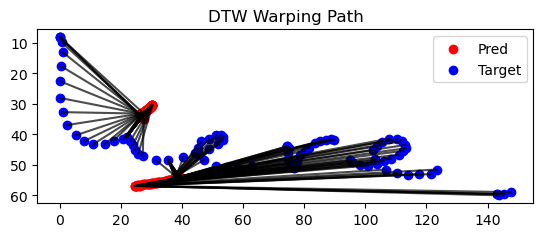

Epoch 23:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 203.9288
   Batch: 100  | Width: 46  | Loss: 262.3159
   Batch: 200  | Width: 56  | Loss: 277.9580
   Batch: 300  | Width: 64  | Loss: 253.5778
   Batch: 400  | Width: 72  | Loss: 231.7711
   Batch: 500  | Width: 78  | Loss: 284.2441
   Batch: 600  | Width: 84  | Loss: 254.4414
   Batch: 700  | Width: 90  | Loss: 312.4617
   Batch: 800  | Width: 96  | Loss: 241.2844
   Batch: 900  | Width: 102 | Loss: 291.2033
   Batch: 1000 | Width: 108 | Loss: 320.4007
   Batch: 1100 | Width: 114 | Loss: 308.4867
   Batch: 1200 | Width: 120 | Loss: 275.0432
   Batch: 1300 | Width: 126 | Loss: 317.5130
   Batch: 1400 | Width: 134 | Loss: 345.7049
   Batch: 1500 | Width: 140 | Loss: 362.5708
   Batch: 1600 | Width: 148 | Loss: 433.7680
   Batch: 1700 | Width: 156 | Loss: 341.7805
   Batch: 1800 | Width: 166 | Loss: 497.3918
   Batch: 1900 | Width: 176 | Loss: 438.8696
   Batch: 2000 | Width: 188 | Loss: 431.8682
   Batch: 2100 | Width: 200 | Loss: 416.8383
   Batch: 

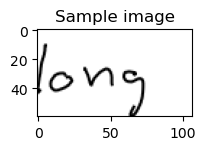

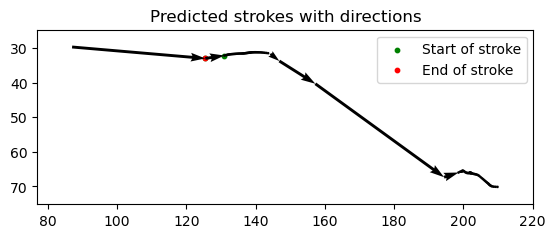

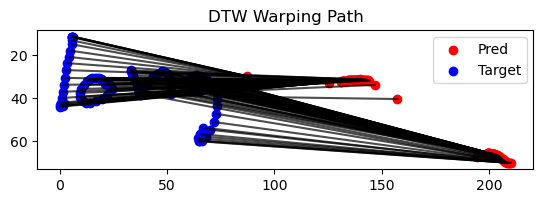

Epoch 24:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 235.6983
   Batch: 100  | Width: 46  | Loss: 267.7104
   Batch: 200  | Width: 56  | Loss: 261.7540
   Batch: 300  | Width: 64  | Loss: 235.0822
   Batch: 400  | Width: 72  | Loss: 220.8924
   Batch: 500  | Width: 78  | Loss: 266.8352
   Batch: 600  | Width: 84  | Loss: 258.8042
   Batch: 700  | Width: 90  | Loss: 254.3438
   Batch: 800  | Width: 96  | Loss: 221.9376
   Batch: 900  | Width: 102 | Loss: 276.5703
   Batch: 1000 | Width: 108 | Loss: 316.7369
   Batch: 1100 | Width: 114 | Loss: 318.4463
   Batch: 1200 | Width: 120 | Loss: 305.0464
   Batch: 1300 | Width: 126 | Loss: 317.0430
   Batch: 1400 | Width: 134 | Loss: 365.3406
   Batch: 1500 | Width: 140 | Loss: 343.3181
   Batch: 1600 | Width: 148 | Loss: 410.9694
   Batch: 1700 | Width: 156 | Loss: 360.3251
   Batch: 1800 | Width: 166 | Loss: 430.3009
   Batch: 1900 | Width: 176 | Loss: 392.1320
   Batch: 2000 | Width: 188 | Loss: 448.6772
   Batch: 2100 | Width: 200 | Loss: 424.3079
   Batch: 

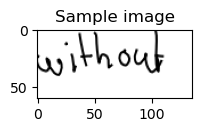

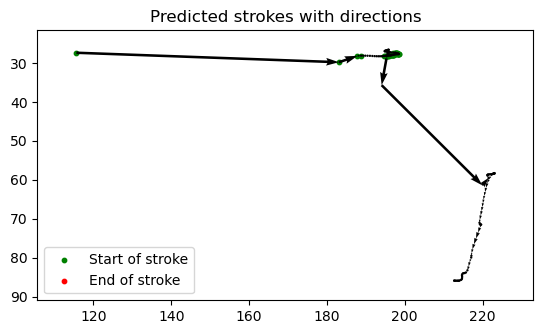

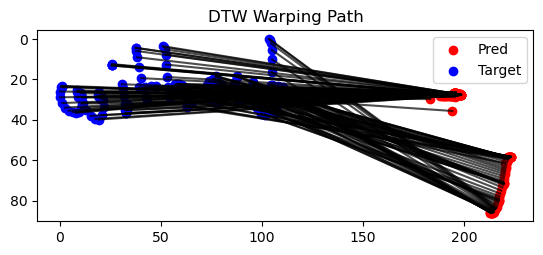

Epoch 25:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 292.7310
   Batch: 100  | Width: 46  | Loss: 254.8697
   Batch: 200  | Width: 56  | Loss: 262.4625
   Batch: 300  | Width: 64  | Loss: 244.2186
   Batch: 400  | Width: 72  | Loss: 229.8729
   Batch: 500  | Width: 78  | Loss: 249.4264
   Batch: 600  | Width: 84  | Loss: 269.8768
   Batch: 700  | Width: 90  | Loss: 276.4815
   Batch: 800  | Width: 96  | Loss: 231.2952
   Batch: 900  | Width: 102 | Loss: 268.3896
   Batch: 1000 | Width: 108 | Loss: 313.2380
   Batch: 1100 | Width: 114 | Loss: 276.5699
   Batch: 1200 | Width: 120 | Loss: 291.0534
   Batch: 1300 | Width: 126 | Loss: 372.6494
   Batch: 1400 | Width: 134 | Loss: 363.7777
   Batch: 1500 | Width: 140 | Loss: 367.0718
   Batch: 1600 | Width: 148 | Loss: 411.4115
   Batch: 1700 | Width: 156 | Loss: 360.4960
   Batch: 1800 | Width: 166 | Loss: 449.4929
   Batch: 1900 | Width: 176 | Loss: 401.3506
   Batch: 2000 | Width: 188 | Loss: 446.1996
   Batch: 2100 | Width: 200 | Loss: 415.6021
   Batch: 

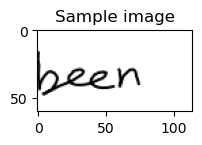

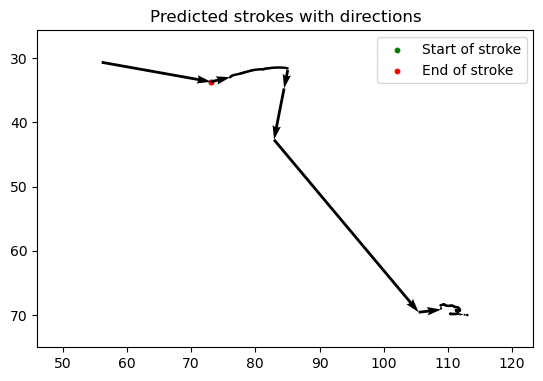

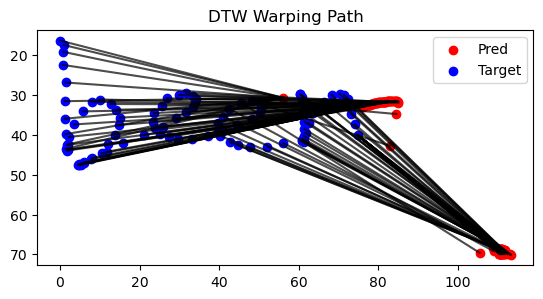

Epoch 26:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 205.0019
   Batch: 100  | Width: 46  | Loss: 262.7652
   Batch: 200  | Width: 56  | Loss: 255.5364
   Batch: 300  | Width: 64  | Loss: 273.2883
   Batch: 400  | Width: 72  | Loss: 220.7407
   Batch: 500  | Width: 78  | Loss: 280.0932
   Batch: 600  | Width: 84  | Loss: 260.6687
   Batch: 700  | Width: 90  | Loss: 276.8094
   Batch: 800  | Width: 96  | Loss: 233.8927
   Batch: 900  | Width: 102 | Loss: 284.1871
   Batch: 1000 | Width: 108 | Loss: 333.5905
   Batch: 1100 | Width: 114 | Loss: 313.5336
   Batch: 1200 | Width: 120 | Loss: 319.6873
   Batch: 1300 | Width: 126 | Loss: 368.3554
   Batch: 1400 | Width: 134 | Loss: 383.3996
   Batch: 1500 | Width: 140 | Loss: 330.2087
   Batch: 1600 | Width: 148 | Loss: 409.8624
   Batch: 1700 | Width: 156 | Loss: 378.3923
   Batch: 1800 | Width: 166 | Loss: 427.8699
   Batch: 1900 | Width: 176 | Loss: 348.5466
   Batch: 2000 | Width: 188 | Loss: 430.3306
   Batch: 2100 | Width: 200 | Loss: 398.8600
   Batch: 

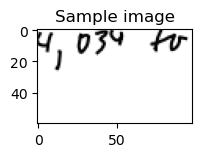

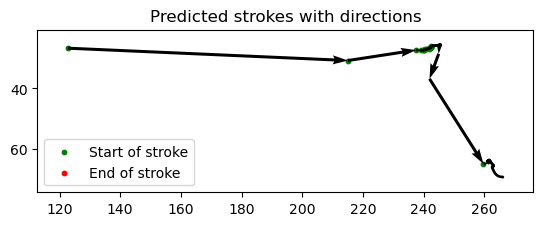

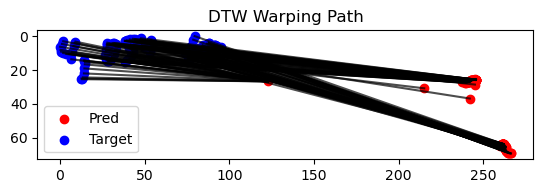

Epoch 27:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 197.7393
   Batch: 100  | Width: 46  | Loss: 268.5096
   Batch: 200  | Width: 56  | Loss: 253.6729
   Batch: 300  | Width: 64  | Loss: 256.5690
   Batch: 400  | Width: 72  | Loss: 228.7694
   Batch: 500  | Width: 78  | Loss: 291.5541
   Batch: 600  | Width: 84  | Loss: 251.2004
   Batch: 700  | Width: 90  | Loss: 254.5079
   Batch: 800  | Width: 96  | Loss: 249.1711
   Batch: 900  | Width: 102 | Loss: 277.4289
   Batch: 1000 | Width: 108 | Loss: 291.5182
   Batch: 1100 | Width: 114 | Loss: 311.3960
   Batch: 1200 | Width: 120 | Loss: 304.4808
   Batch: 1300 | Width: 126 | Loss: 374.2451
   Batch: 1400 | Width: 134 | Loss: 395.5539
   Batch: 1500 | Width: 140 | Loss: 326.7690
   Batch: 1600 | Width: 148 | Loss: 369.8810
   Batch: 1700 | Width: 156 | Loss: 337.0320
   Batch: 1800 | Width: 166 | Loss: 413.8455
   Batch: 1900 | Width: 176 | Loss: 389.5522
   Batch: 2000 | Width: 188 | Loss: 419.3252
   Batch: 2100 | Width: 200 | Loss: 399.3144
   Batch: 

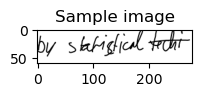

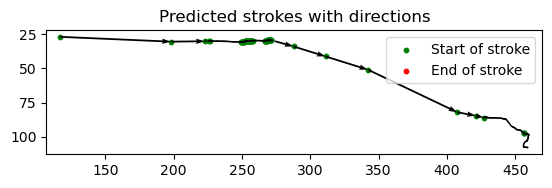

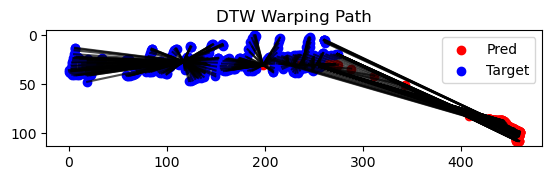

Epoch 28:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 210.9797
   Batch: 100  | Width: 46  | Loss: 259.3767
   Batch: 200  | Width: 56  | Loss: 262.8813
   Batch: 300  | Width: 64  | Loss: 232.7655
   Batch: 400  | Width: 72  | Loss: 219.1998
   Batch: 500  | Width: 78  | Loss: 285.3086
   Batch: 600  | Width: 84  | Loss: 259.2315
   Batch: 700  | Width: 90  | Loss: 245.5618
   Batch: 800  | Width: 96  | Loss: 235.4324
   Batch: 900  | Width: 102 | Loss: 305.2456
   Batch: 1000 | Width: 108 | Loss: 293.7944
   Batch: 1100 | Width: 114 | Loss: 325.7595
   Batch: 1200 | Width: 120 | Loss: 324.1190
   Batch: 1300 | Width: 126 | Loss: 338.0738
   Batch: 1400 | Width: 134 | Loss: 383.9632
   Batch: 1500 | Width: 140 | Loss: 350.2325
   Batch: 1600 | Width: 148 | Loss: 400.3457
   Batch: 1700 | Width: 156 | Loss: 347.1880
   Batch: 1800 | Width: 166 | Loss: 444.1239
   Batch: 1900 | Width: 176 | Loss: 434.9523
   Batch: 2000 | Width: 188 | Loss: 461.0081
   Batch: 2100 | Width: 200 | Loss: 443.4539
   Batch: 

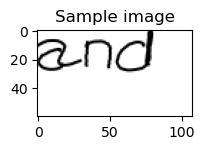

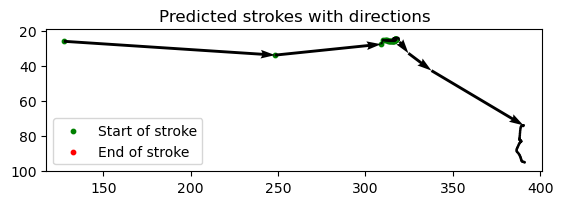

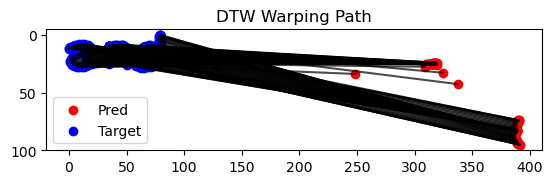

Epoch 29:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 189.3749
   Batch: 100  | Width: 46  | Loss: 273.0374
   Batch: 200  | Width: 56  | Loss: 269.2292
   Batch: 300  | Width: 64  | Loss: 255.4334
   Batch: 400  | Width: 72  | Loss: 231.0539
   Batch: 500  | Width: 78  | Loss: 294.6523
   Batch: 600  | Width: 84  | Loss: 259.7829
   Batch: 700  | Width: 90  | Loss: 249.2317
   Batch: 800  | Width: 96  | Loss: 224.6470
   Batch: 900  | Width: 102 | Loss: 279.0701
   Batch: 1000 | Width: 108 | Loss: 316.3491
   Batch: 1100 | Width: 114 | Loss: 302.6084
   Batch: 1200 | Width: 120 | Loss: 281.9644
   Batch: 1300 | Width: 126 | Loss: 368.9124
   Batch: 1400 | Width: 134 | Loss: 378.0315
   Batch: 1500 | Width: 140 | Loss: 324.2833
   Batch: 1600 | Width: 148 | Loss: 379.6824
   Batch: 1700 | Width: 156 | Loss: 351.6350
   Batch: 1800 | Width: 166 | Loss: 429.7265
   Batch: 1900 | Width: 176 | Loss: 349.4744
   Batch: 2000 | Width: 188 | Loss: 460.5280
   Batch: 2100 | Width: 200 | Loss: 417.9901
   Batch: 

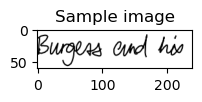

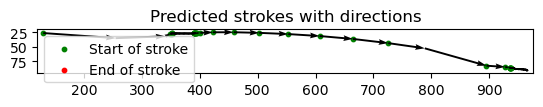

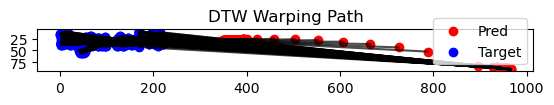

Epoch 30:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 199.8431
   Batch: 100  | Width: 46  | Loss: 255.9239
   Batch: 200  | Width: 56  | Loss: 251.8161
   Batch: 300  | Width: 64  | Loss: 245.5225
   Batch: 400  | Width: 72  | Loss: 230.3039
   Batch: 500  | Width: 78  | Loss: 248.8204
   Batch: 600  | Width: 84  | Loss: 244.4518
   Batch: 700  | Width: 90  | Loss: 248.6356
   Batch: 800  | Width: 96  | Loss: 254.5313
   Batch: 900  | Width: 102 | Loss: 286.6568
   Batch: 1000 | Width: 108 | Loss: 268.5632
   Batch: 1100 | Width: 114 | Loss: 333.1282
   Batch: 1200 | Width: 120 | Loss: 263.4813
   Batch: 1300 | Width: 126 | Loss: 369.7927
   Batch: 1400 | Width: 134 | Loss: 387.4741
   Batch: 1500 | Width: 140 | Loss: 316.3569
   Batch: 1600 | Width: 148 | Loss: 426.2539
   Batch: 1700 | Width: 156 | Loss: 328.4803
   Batch: 1800 | Width: 166 | Loss: 459.9921
   Batch: 1900 | Width: 176 | Loss: 381.5796
   Batch: 2000 | Width: 188 | Loss: 440.6352
   Batch: 2100 | Width: 200 | Loss: 393.6683
   Batch: 

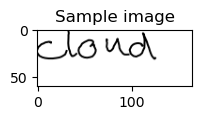

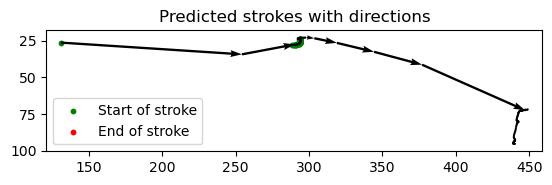

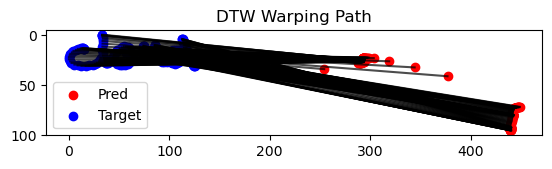

Epoch 31:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 190.2348
   Batch: 100  | Width: 46  | Loss: 258.9702
   Batch: 200  | Width: 56  | Loss: 246.2068
   Batch: 300  | Width: 64  | Loss: 256.1185
   Batch: 400  | Width: 72  | Loss: 227.9507
   Batch: 500  | Width: 78  | Loss: 273.6404
   Batch: 600  | Width: 84  | Loss: 236.8924
   Batch: 700  | Width: 90  | Loss: 265.1332
   Batch: 800  | Width: 96  | Loss: 247.7097
   Batch: 900  | Width: 102 | Loss: 287.2990
   Batch: 1000 | Width: 108 | Loss: 275.9505
   Batch: 1100 | Width: 114 | Loss: 315.2166
   Batch: 1200 | Width: 120 | Loss: 317.3088
   Batch: 1300 | Width: 126 | Loss: 344.0479
   Batch: 1400 | Width: 134 | Loss: 383.6610
   Batch: 1500 | Width: 140 | Loss: 305.6298
   Batch: 1600 | Width: 148 | Loss: 403.8113
   Batch: 1700 | Width: 156 | Loss: 335.5628
   Batch: 1800 | Width: 166 | Loss: 458.4661
   Batch: 1900 | Width: 176 | Loss: 402.2729
   Batch: 2000 | Width: 188 | Loss: 445.1414
   Batch: 2100 | Width: 200 | Loss: 413.6698
   Batch: 

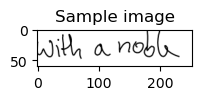

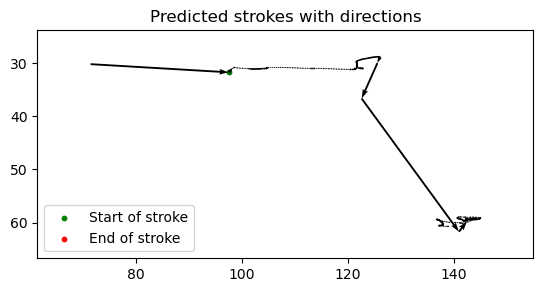

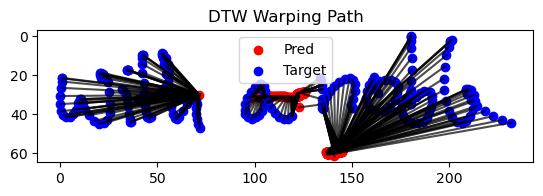

Epoch 32:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 199.7852
   Batch: 100  | Width: 46  | Loss: 270.7872
   Batch: 200  | Width: 56  | Loss: 252.3541
   Batch: 300  | Width: 64  | Loss: 249.7439
   Batch: 400  | Width: 72  | Loss: 224.8170
   Batch: 500  | Width: 78  | Loss: 282.1170
   Batch: 600  | Width: 84  | Loss: 239.2590
   Batch: 700  | Width: 90  | Loss: 258.5965
   Batch: 800  | Width: 96  | Loss: 239.4641
   Batch: 900  | Width: 102 | Loss: 290.1321
   Batch: 1000 | Width: 108 | Loss: 289.2283
   Batch: 1100 | Width: 114 | Loss: 329.2018
   Batch: 1200 | Width: 120 | Loss: 355.4579
   Batch: 1300 | Width: 126 | Loss: 338.2173
   Batch: 1400 | Width: 134 | Loss: 381.1008
   Batch: 1500 | Width: 140 | Loss: 318.3417
   Batch: 1600 | Width: 148 | Loss: 387.9643
   Batch: 1700 | Width: 156 | Loss: 377.1918
   Batch: 1800 | Width: 166 | Loss: 449.3537
   Batch: 1900 | Width: 176 | Loss: 435.2137
   Batch: 2000 | Width: 188 | Loss: 430.9515
   Batch: 2100 | Width: 200 | Loss: 415.4965
   Batch: 

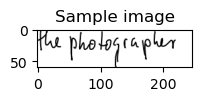

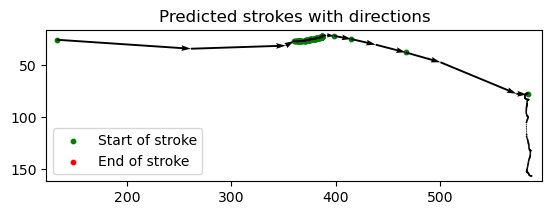

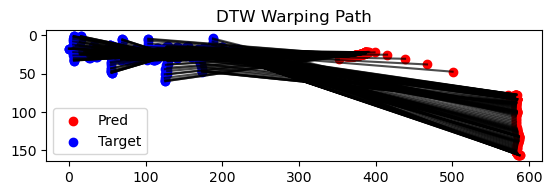

Epoch 33:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 199.3195
   Batch: 100  | Width: 46  | Loss: 260.3538
   Batch: 200  | Width: 56  | Loss: 286.3766
   Batch: 300  | Width: 64  | Loss: 251.2864
   Batch: 400  | Width: 72  | Loss: 234.7334
   Batch: 500  | Width: 78  | Loss: 256.7080
   Batch: 600  | Width: 84  | Loss: 254.3490
   Batch: 700  | Width: 90  | Loss: 255.3246
   Batch: 800  | Width: 96  | Loss: 222.8579
   Batch: 900  | Width: 102 | Loss: 275.0182
   Batch: 1000 | Width: 108 | Loss: 273.3012
   Batch: 1100 | Width: 114 | Loss: 336.0755
   Batch: 1200 | Width: 120 | Loss: 310.4866
   Batch: 1300 | Width: 126 | Loss: 346.6109
   Batch: 1400 | Width: 134 | Loss: 398.7264
   Batch: 1500 | Width: 140 | Loss: 337.0624
   Batch: 1600 | Width: 148 | Loss: 394.9717
   Batch: 1700 | Width: 156 | Loss: 367.2789
   Batch: 1800 | Width: 166 | Loss: 435.6703
   Batch: 1900 | Width: 176 | Loss: 418.2542
   Batch: 2000 | Width: 188 | Loss: 478.2506
   Batch: 2100 | Width: 200 | Loss: 410.2597
   Batch: 

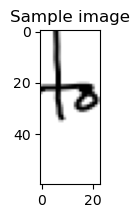

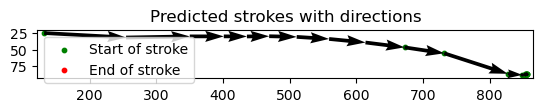

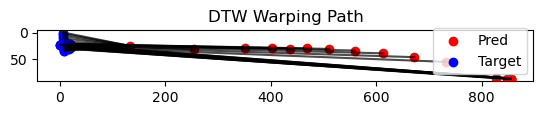

Epoch 34:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 186.1967
   Batch: 100  | Width: 46  | Loss: 256.5782
   Batch: 200  | Width: 56  | Loss: 265.9270
   Batch: 300  | Width: 64  | Loss: 250.3795
   Batch: 400  | Width: 72  | Loss: 211.1098
   Batch: 500  | Width: 78  | Loss: 279.3540
   Batch: 600  | Width: 84  | Loss: 226.4003
   Batch: 700  | Width: 90  | Loss: 276.6268
   Batch: 800  | Width: 96  | Loss: 250.8050
   Batch: 900  | Width: 102 | Loss: 287.0473
   Batch: 1000 | Width: 108 | Loss: 289.2483
   Batch: 1100 | Width: 114 | Loss: 328.9825
   Batch: 1200 | Width: 120 | Loss: 280.0116
   Batch: 1300 | Width: 126 | Loss: 329.3618
   Batch: 1400 | Width: 134 | Loss: 382.0182
   Batch: 1500 | Width: 140 | Loss: 328.2374
   Batch: 1600 | Width: 148 | Loss: 367.0512
   Batch: 1700 | Width: 156 | Loss: 344.0970
   Batch: 1800 | Width: 166 | Loss: 448.2100
   Batch: 1900 | Width: 176 | Loss: 420.9746
   Batch: 2000 | Width: 188 | Loss: 458.8023
   Batch: 2100 | Width: 200 | Loss: 414.7666
   Batch: 

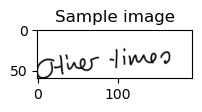

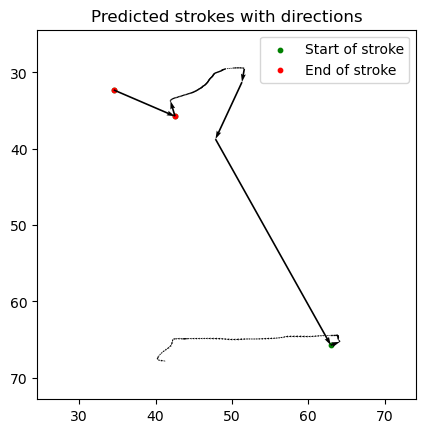

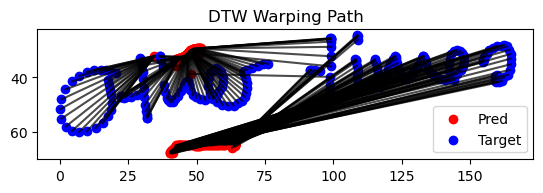

Epoch 35:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 172.0453
   Batch: 100  | Width: 46  | Loss: 249.7173
   Batch: 200  | Width: 56  | Loss: 256.8094
   Batch: 300  | Width: 64  | Loss: 241.0442
   Batch: 400  | Width: 72  | Loss: 229.9564
   Batch: 500  | Width: 78  | Loss: 250.1084
   Batch: 600  | Width: 84  | Loss: 238.7009
   Batch: 700  | Width: 90  | Loss: 281.2425
   Batch: 800  | Width: 96  | Loss: 245.6897
   Batch: 900  | Width: 102 | Loss: 290.2370
   Batch: 1000 | Width: 108 | Loss: 285.5148
   Batch: 1100 | Width: 114 | Loss: 327.6705
   Batch: 1200 | Width: 120 | Loss: 299.1131
   Batch: 1300 | Width: 126 | Loss: 380.9438
   Batch: 1400 | Width: 134 | Loss: 377.6930
   Batch: 1500 | Width: 140 | Loss: 314.8441
   Batch: 1600 | Width: 148 | Loss: 393.3792
   Batch: 1700 | Width: 156 | Loss: 345.5983
   Batch: 1800 | Width: 166 | Loss: 461.2764
   Batch: 1900 | Width: 176 | Loss: 372.0656
   Batch: 2000 | Width: 188 | Loss: 461.8735
   Batch: 2100 | Width: 200 | Loss: 407.0846
   Batch: 

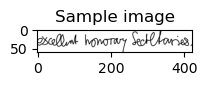

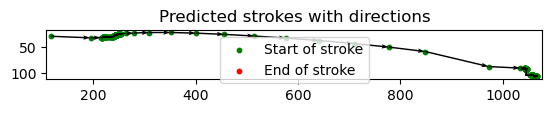

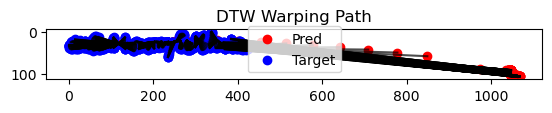

Epoch 36:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 189.6248
   Batch: 100  | Width: 46  | Loss: 262.9328
   Batch: 200  | Width: 56  | Loss: 269.7039
   Batch: 300  | Width: 64  | Loss: 242.2931
   Batch: 400  | Width: 72  | Loss: 224.9742
   Batch: 500  | Width: 78  | Loss: 281.5330
   Batch: 600  | Width: 84  | Loss: 249.9648
   Batch: 700  | Width: 90  | Loss: 261.3555
   Batch: 800  | Width: 96  | Loss: 250.2805
   Batch: 900  | Width: 102 | Loss: 284.5224
   Batch: 1000 | Width: 108 | Loss: 301.2133
   Batch: 1100 | Width: 114 | Loss: 329.4829
   Batch: 1200 | Width: 120 | Loss: 295.0298
   Batch: 1300 | Width: 126 | Loss: 378.0576
   Batch: 1400 | Width: 134 | Loss: 383.4156
   Batch: 1500 | Width: 140 | Loss: 334.3957
   Batch: 1600 | Width: 148 | Loss: 378.8594
   Batch: 1700 | Width: 156 | Loss: 334.1001
   Batch: 1800 | Width: 166 | Loss: 441.3530
   Batch: 1900 | Width: 176 | Loss: 355.1100
   Batch: 2000 | Width: 188 | Loss: 449.0971
   Batch: 2100 | Width: 200 | Loss: 389.9974
   Batch: 

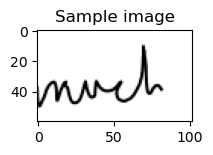

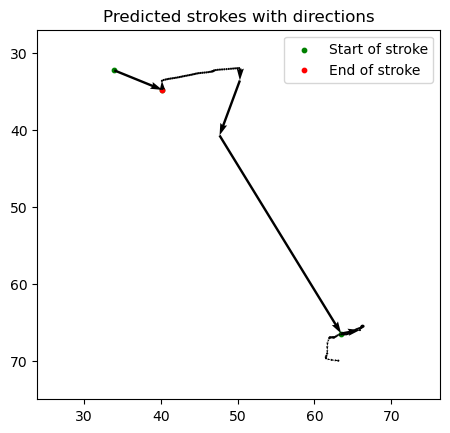

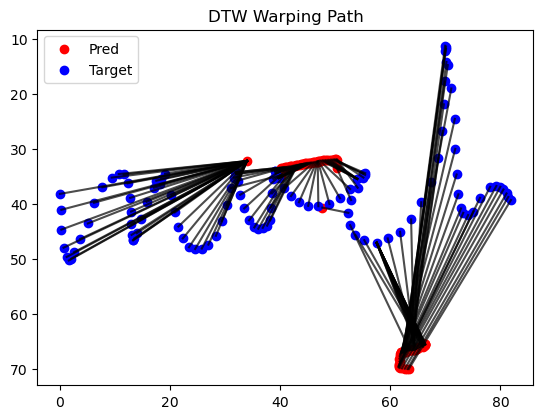

Epoch 37:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 187.0297
   Batch: 100  | Width: 46  | Loss: 249.0638
   Batch: 200  | Width: 56  | Loss: 262.4577
   Batch: 300  | Width: 64  | Loss: 258.2560
   Batch: 400  | Width: 72  | Loss: 222.9604
   Batch: 500  | Width: 78  | Loss: 265.5253
   Batch: 600  | Width: 84  | Loss: 222.7823
   Batch: 700  | Width: 90  | Loss: 263.6927
   Batch: 800  | Width: 96  | Loss: 225.2038
   Batch: 900  | Width: 102 | Loss: 312.9992
   Batch: 1000 | Width: 108 | Loss: 270.5072
   Batch: 1100 | Width: 114 | Loss: 332.8421
   Batch: 1200 | Width: 120 | Loss: 289.2997
   Batch: 1300 | Width: 126 | Loss: 379.3280
   Batch: 1400 | Width: 134 | Loss: 366.8222
   Batch: 1500 | Width: 140 | Loss: 336.1743
   Batch: 1600 | Width: 148 | Loss: 395.0993
   Batch: 1700 | Width: 156 | Loss: 338.7448
   Batch: 1800 | Width: 166 | Loss: 458.3757
   Batch: 1900 | Width: 176 | Loss: 406.9062
   Batch: 2000 | Width: 188 | Loss: 422.7757
   Batch: 2100 | Width: 200 | Loss: 386.0800
   Batch: 

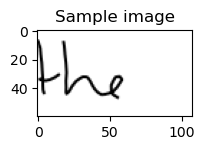

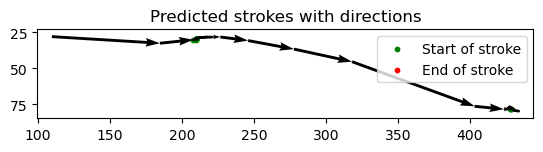

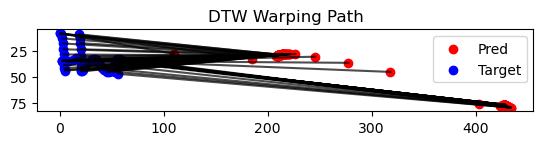

Epoch 38:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 170.1295
   Batch: 100  | Width: 46  | Loss: 255.8019
   Batch: 200  | Width: 56  | Loss: 272.4273
   Batch: 300  | Width: 64  | Loss: 284.9584
   Batch: 400  | Width: 72  | Loss: 225.0441
   Batch: 500  | Width: 78  | Loss: 267.3926
   Batch: 600  | Width: 84  | Loss: 242.5358
   Batch: 700  | Width: 90  | Loss: 278.3853
   Batch: 800  | Width: 96  | Loss: 230.2437
   Batch: 900  | Width: 102 | Loss: 316.1041
   Batch: 1000 | Width: 108 | Loss: 289.8345
   Batch: 1100 | Width: 114 | Loss: 322.4611
   Batch: 1200 | Width: 120 | Loss: 302.2109
   Batch: 1300 | Width: 126 | Loss: 366.9184
   Batch: 1400 | Width: 134 | Loss: 372.5297
   Batch: 1500 | Width: 140 | Loss: 334.6203
   Batch: 1600 | Width: 148 | Loss: 402.6909
   Batch: 1700 | Width: 156 | Loss: 342.2589
   Batch: 1800 | Width: 166 | Loss: 424.0903
   Batch: 1900 | Width: 176 | Loss: 408.1735
   Batch: 2000 | Width: 188 | Loss: 463.6720
   Batch: 2100 | Width: 200 | Loss: 398.1748
   Batch: 

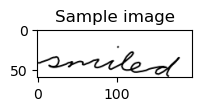

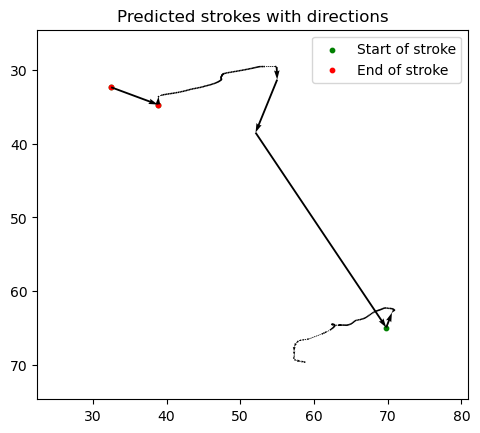

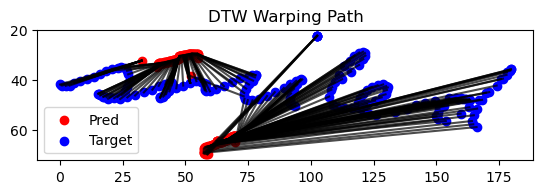

Epoch 39:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 188.4245
   Batch: 100  | Width: 46  | Loss: 249.2535
   Batch: 200  | Width: 56  | Loss: 264.6599
   Batch: 300  | Width: 64  | Loss: 262.6220
   Batch: 400  | Width: 72  | Loss: 236.3572
   Batch: 500  | Width: 78  | Loss: 256.6589
   Batch: 600  | Width: 84  | Loss: 236.5850
   Batch: 700  | Width: 90  | Loss: 273.3222
   Batch: 800  | Width: 96  | Loss: 235.6681
   Batch: 900  | Width: 102 | Loss: 292.8518
   Batch: 1000 | Width: 108 | Loss: 287.5435
   Batch: 1100 | Width: 114 | Loss: 324.7700
   Batch: 1200 | Width: 120 | Loss: 293.0013
   Batch: 1300 | Width: 126 | Loss: 345.0529
   Batch: 1400 | Width: 134 | Loss: 357.8074
   Batch: 1500 | Width: 140 | Loss: 331.4099
   Batch: 1600 | Width: 148 | Loss: 399.9026
   Batch: 1700 | Width: 156 | Loss: 346.5992
   Batch: 1800 | Width: 166 | Loss: 407.3611
   Batch: 1900 | Width: 176 | Loss: 383.8534
   Batch: 2000 | Width: 188 | Loss: 473.5057
   Batch: 2100 | Width: 200 | Loss: 383.6522
   Batch: 

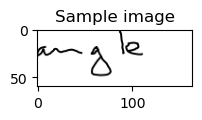

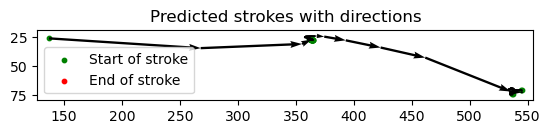

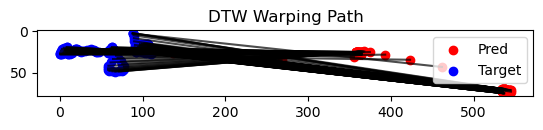

Epoch 40:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 176.0417
   Batch: 100  | Width: 46  | Loss: 244.8270
   Batch: 200  | Width: 56  | Loss: 255.7212
   Batch: 300  | Width: 64  | Loss: 265.4626
   Batch: 400  | Width: 72  | Loss: 234.6182
   Batch: 500  | Width: 78  | Loss: 263.8729
   Batch: 600  | Width: 84  | Loss: 232.3611
   Batch: 700  | Width: 90  | Loss: 270.1482
   Batch: 800  | Width: 96  | Loss: 243.8409
   Batch: 900  | Width: 102 | Loss: 281.1568
   Batch: 1000 | Width: 108 | Loss: 284.7355
   Batch: 1100 | Width: 114 | Loss: 338.7901
   Batch: 1200 | Width: 120 | Loss: 316.5766
   Batch: 1300 | Width: 126 | Loss: 341.5773
   Batch: 1400 | Width: 134 | Loss: 381.8109
   Batch: 1500 | Width: 140 | Loss: 346.4458
   Batch: 1600 | Width: 148 | Loss: 353.0086
   Batch: 1700 | Width: 156 | Loss: 339.4276
   Batch: 1800 | Width: 166 | Loss: 431.9248
   Batch: 1900 | Width: 176 | Loss: 363.2059
   Batch: 2000 | Width: 188 | Loss: 453.7002
   Batch: 2100 | Width: 200 | Loss: 378.9552
   Batch: 

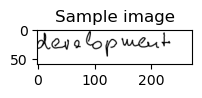

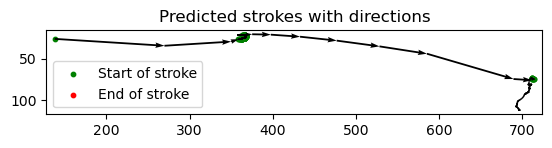

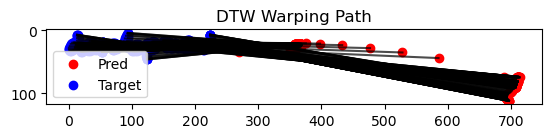

Epoch 41:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 172.8164
   Batch: 100  | Width: 46  | Loss: 255.5682
   Batch: 200  | Width: 56  | Loss: 264.2218
   Batch: 300  | Width: 64  | Loss: 243.7920
   Batch: 400  | Width: 72  | Loss: 221.2277
   Batch: 500  | Width: 78  | Loss: 254.6967
   Batch: 600  | Width: 84  | Loss: 229.5283
   Batch: 700  | Width: 90  | Loss: 275.3532
   Batch: 800  | Width: 96  | Loss: 264.6653
   Batch: 900  | Width: 102 | Loss: 313.7852
   Batch: 1000 | Width: 108 | Loss: 268.1637
   Batch: 1100 | Width: 114 | Loss: 311.7618
   Batch: 1200 | Width: 120 | Loss: 318.7812
   Batch: 1300 | Width: 126 | Loss: 367.7149
   Batch: 1400 | Width: 134 | Loss: 378.2706
   Batch: 1500 | Width: 140 | Loss: 314.3300
   Batch: 1600 | Width: 148 | Loss: 377.4491
   Batch: 1700 | Width: 156 | Loss: 351.6565
   Batch: 1800 | Width: 166 | Loss: 412.0411
   Batch: 1900 | Width: 176 | Loss: 381.4275
   Batch: 2000 | Width: 188 | Loss: 422.1734
   Batch: 2100 | Width: 200 | Loss: 401.3505
   Batch: 

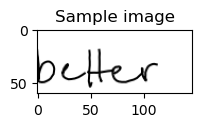

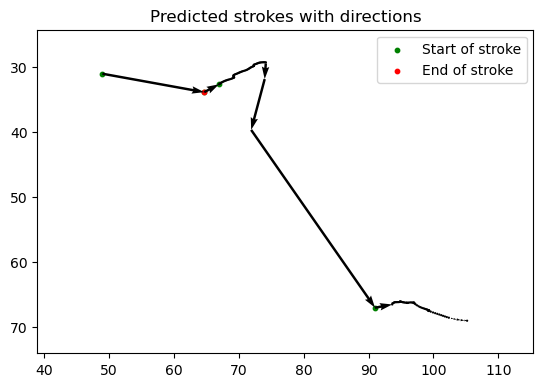

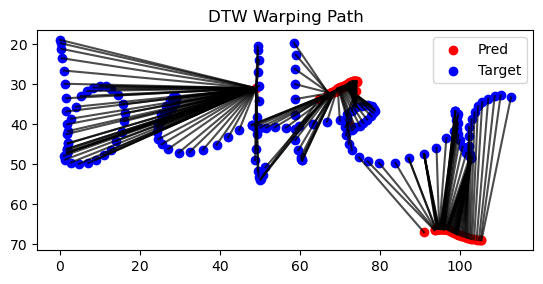

Epoch 42:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 166.4917
   Batch: 100  | Width: 46  | Loss: 246.0230
   Batch: 200  | Width: 56  | Loss: 254.3139
   Batch: 300  | Width: 64  | Loss: 238.8679
   Batch: 400  | Width: 72  | Loss: 222.5570
   Batch: 500  | Width: 78  | Loss: 251.4157
   Batch: 600  | Width: 84  | Loss: 224.1423
   Batch: 700  | Width: 90  | Loss: 267.2414
   Batch: 800  | Width: 96  | Loss: 240.0500
   Batch: 900  | Width: 102 | Loss: 294.9333
   Batch: 1000 | Width: 108 | Loss: 288.8635
   Batch: 1100 | Width: 114 | Loss: 307.0826
   Batch: 1200 | Width: 120 | Loss: 304.3619
   Batch: 1300 | Width: 126 | Loss: 396.6972
   Batch: 1400 | Width: 134 | Loss: 389.3903
   Batch: 1500 | Width: 140 | Loss: 314.5726
   Batch: 1600 | Width: 148 | Loss: 374.6524
   Batch: 1700 | Width: 156 | Loss: 365.5411
   Batch: 1800 | Width: 166 | Loss: 418.4808
   Batch: 1900 | Width: 176 | Loss: 410.6550
   Batch: 2000 | Width: 188 | Loss: 438.0828
   Batch: 2100 | Width: 200 | Loss: 434.1027
   Batch: 

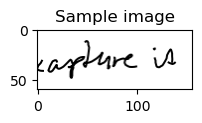

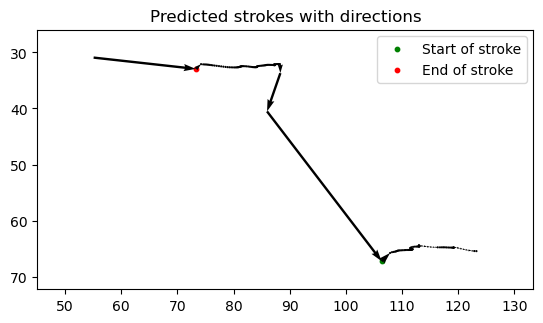

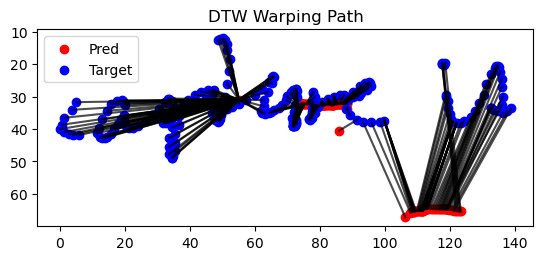

Epoch 43:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 176.6865
   Batch: 100  | Width: 46  | Loss: 238.0218
   Batch: 200  | Width: 56  | Loss: 268.7100
   Batch: 300  | Width: 64  | Loss: 258.0182
   Batch: 400  | Width: 72  | Loss: 219.9865
   Batch: 500  | Width: 78  | Loss: 255.8893
   Batch: 600  | Width: 84  | Loss: 233.0383
   Batch: 700  | Width: 90  | Loss: 279.8947
   Batch: 800  | Width: 96  | Loss: 240.4107
   Batch: 900  | Width: 102 | Loss: 286.0464
   Batch: 1000 | Width: 108 | Loss: 286.9791
   Batch: 1100 | Width: 114 | Loss: 336.1803
   Batch: 1200 | Width: 120 | Loss: 305.5213
   Batch: 1300 | Width: 126 | Loss: 372.7056
   Batch: 1400 | Width: 134 | Loss: 359.9046
   Batch: 1500 | Width: 140 | Loss: 305.8591
   Batch: 1600 | Width: 148 | Loss: 414.8679
   Batch: 1700 | Width: 156 | Loss: 349.7598
   Batch: 1800 | Width: 166 | Loss: 407.9075
   Batch: 1900 | Width: 176 | Loss: 376.7029
   Batch: 2000 | Width: 188 | Loss: 483.0218
   Batch: 2100 | Width: 200 | Loss: 403.7530
   Batch: 

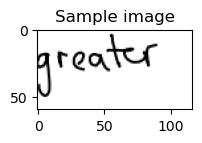

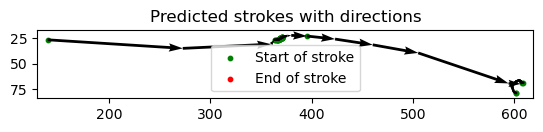

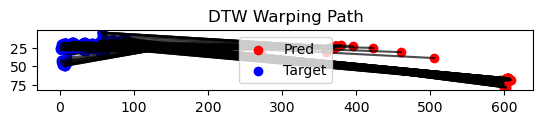

Epoch 44:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 183.5021
   Batch: 100  | Width: 46  | Loss: 249.0192
   Batch: 200  | Width: 56  | Loss: 252.4950
   Batch: 300  | Width: 64  | Loss: 262.2370
   Batch: 400  | Width: 72  | Loss: 218.6545
   Batch: 500  | Width: 78  | Loss: 255.1231
   Batch: 600  | Width: 84  | Loss: 225.8882
   Batch: 700  | Width: 90  | Loss: 266.5480
   Batch: 800  | Width: 96  | Loss: 244.7292
   Batch: 900  | Width: 102 | Loss: 299.4297
   Batch: 1000 | Width: 108 | Loss: 298.9542
   Batch: 1100 | Width: 114 | Loss: 321.1591
   Batch: 1200 | Width: 120 | Loss: 314.4723
   Batch: 1300 | Width: 126 | Loss: 379.1758
   Batch: 1400 | Width: 134 | Loss: 382.3406
   Batch: 1500 | Width: 140 | Loss: 313.1473
   Batch: 1600 | Width: 148 | Loss: 380.5297
   Batch: 1700 | Width: 156 | Loss: 348.2711
   Batch: 1800 | Width: 166 | Loss: 422.1011
   Batch: 1900 | Width: 176 | Loss: 377.4224
   Batch: 2000 | Width: 188 | Loss: 446.9286
   Batch: 2100 | Width: 200 | Loss: 392.5850
   Batch: 

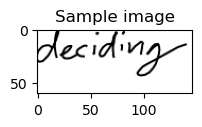

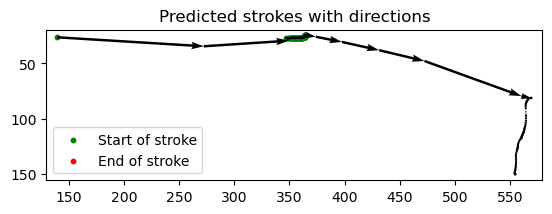

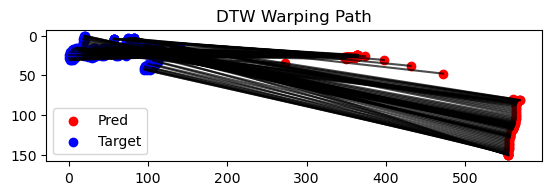

Epoch 45:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 160.4500
   Batch: 100  | Width: 46  | Loss: 251.4478
   Batch: 200  | Width: 56  | Loss: 244.8979
   Batch: 300  | Width: 64  | Loss: 260.9729
   Batch: 400  | Width: 72  | Loss: 227.1792
   Batch: 500  | Width: 78  | Loss: 262.8081
   Batch: 600  | Width: 84  | Loss: 228.1692
   Batch: 700  | Width: 90  | Loss: 269.7415
   Batch: 800  | Width: 96  | Loss: 240.7070
   Batch: 900  | Width: 102 | Loss: 314.4217
   Batch: 1000 | Width: 108 | Loss: 305.7378
   Batch: 1100 | Width: 114 | Loss: 331.2922
   Batch: 1200 | Width: 120 | Loss: 294.7814
   Batch: 1300 | Width: 126 | Loss: 370.0699
   Batch: 1400 | Width: 134 | Loss: 385.6145
   Batch: 1500 | Width: 140 | Loss: 333.9375
   Batch: 1600 | Width: 148 | Loss: 367.4180
   Batch: 1700 | Width: 156 | Loss: 353.0413
   Batch: 1800 | Width: 166 | Loss: 399.2720
   Batch: 1900 | Width: 176 | Loss: 370.9838
   Batch: 2000 | Width: 188 | Loss: 486.9902
   Batch: 2100 | Width: 200 | Loss: 395.3808
   Batch: 

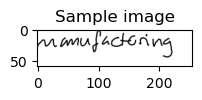

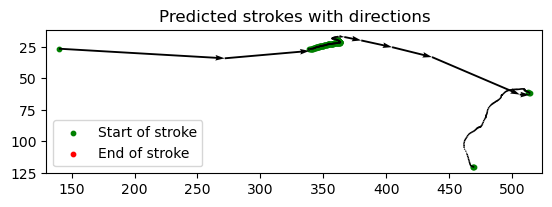

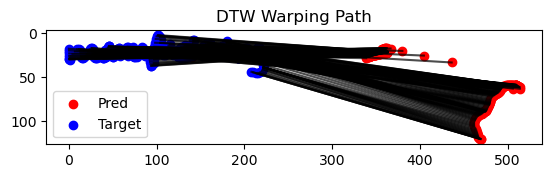

Epoch 46:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 179.4536
   Batch: 100  | Width: 46  | Loss: 241.1734
   Batch: 200  | Width: 56  | Loss: 259.9441
   Batch: 300  | Width: 64  | Loss: 250.2762
   Batch: 400  | Width: 72  | Loss: 224.2550
   Batch: 500  | Width: 78  | Loss: 248.0779
   Batch: 600  | Width: 84  | Loss: 218.7247
   Batch: 700  | Width: 90  | Loss: 253.7601
   Batch: 800  | Width: 96  | Loss: 258.4882
   Batch: 900  | Width: 102 | Loss: 284.9598
   Batch: 1000 | Width: 108 | Loss: 282.6643
   Batch: 1100 | Width: 114 | Loss: 289.2453
   Batch: 1200 | Width: 120 | Loss: 304.3040
   Batch: 1300 | Width: 126 | Loss: 379.5960
   Batch: 1400 | Width: 134 | Loss: 390.7405
   Batch: 1500 | Width: 140 | Loss: 328.4690
   Batch: 1600 | Width: 148 | Loss: 369.0974
   Batch: 1700 | Width: 156 | Loss: 341.1372
   Batch: 1800 | Width: 166 | Loss: 425.1011
   Batch: 1900 | Width: 176 | Loss: 367.3106
   Batch: 2000 | Width: 188 | Loss: 521.0348
   Batch: 2100 | Width: 200 | Loss: 471.7316
   Batch: 

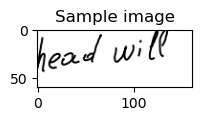

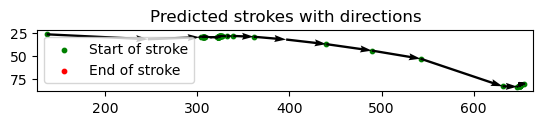

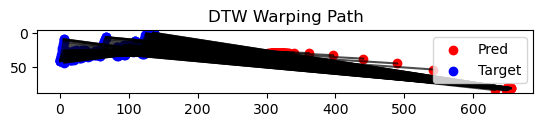

Epoch 47:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 169.3253
   Batch: 100  | Width: 46  | Loss: 252.3422
   Batch: 200  | Width: 56  | Loss: 255.7288
   Batch: 300  | Width: 64  | Loss: 273.0479
   Batch: 400  | Width: 72  | Loss: 240.7520
   Batch: 500  | Width: 78  | Loss: 256.6642
   Batch: 600  | Width: 84  | Loss: 228.8856
   Batch: 700  | Width: 90  | Loss: 278.4009
   Batch: 800  | Width: 96  | Loss: 232.8182
   Batch: 900  | Width: 102 | Loss: 317.8620
   Batch: 1000 | Width: 108 | Loss: 300.6666
   Batch: 1100 | Width: 114 | Loss: 323.9687
   Batch: 1200 | Width: 120 | Loss: 285.2058
   Batch: 1300 | Width: 126 | Loss: 380.2350
   Batch: 1400 | Width: 134 | Loss: 379.9853
   Batch: 1500 | Width: 140 | Loss: 313.2241
   Batch: 1600 | Width: 148 | Loss: 380.9653
   Batch: 1700 | Width: 156 | Loss: 378.4686
   Batch: 1800 | Width: 166 | Loss: 406.1389
   Batch: 1900 | Width: 176 | Loss: 368.7703
   Batch: 2000 | Width: 188 | Loss: 498.6202
   Batch: 2100 | Width: 200 | Loss: 390.9368
   Batch: 

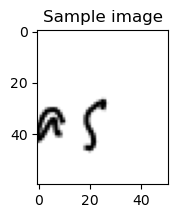

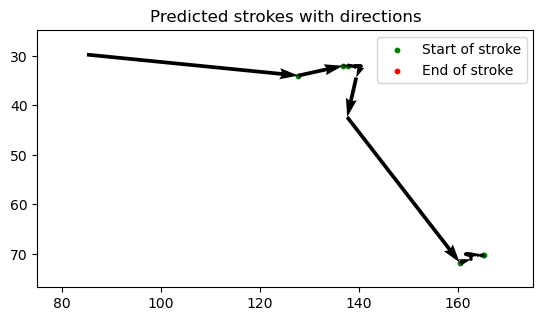

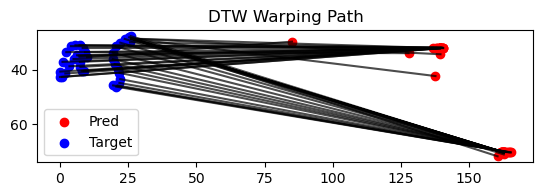

Epoch 48:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 160.6851
   Batch: 100  | Width: 46  | Loss: 246.3697
   Batch: 200  | Width: 56  | Loss: 243.0422
   Batch: 300  | Width: 64  | Loss: 246.7054
   Batch: 400  | Width: 72  | Loss: 213.9304
   Batch: 500  | Width: 78  | Loss: 269.0903
   Batch: 600  | Width: 84  | Loss: 228.9963
   Batch: 700  | Width: 90  | Loss: 274.5898
   Batch: 800  | Width: 96  | Loss: 235.8257
   Batch: 900  | Width: 102 | Loss: 303.8121
   Batch: 1000 | Width: 108 | Loss: 296.8540
   Batch: 1100 | Width: 114 | Loss: 312.4253
   Batch: 1200 | Width: 120 | Loss: 326.5092
   Batch: 1300 | Width: 126 | Loss: 380.7666
   Batch: 1400 | Width: 134 | Loss: 355.1197
   Batch: 1500 | Width: 140 | Loss: 313.4263
   Batch: 1600 | Width: 148 | Loss: 360.5600
   Batch: 1700 | Width: 156 | Loss: 345.2595
   Batch: 1800 | Width: 166 | Loss: 413.1571
   Batch: 1900 | Width: 176 | Loss: 364.8655
   Batch: 2000 | Width: 188 | Loss: 423.6855
   Batch: 2100 | Width: 200 | Loss: 440.1853
   Batch: 

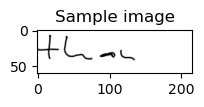

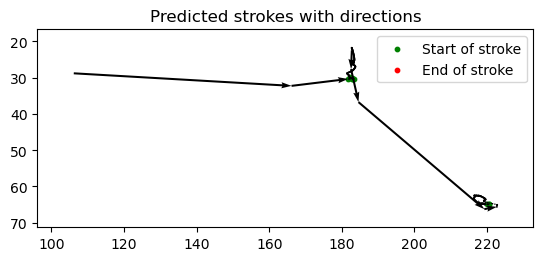

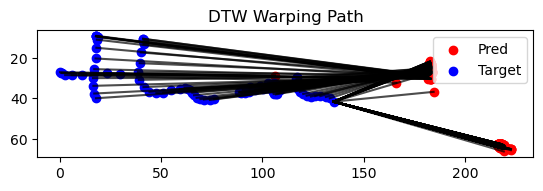

Epoch 49:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 171.6347
   Batch: 100  | Width: 46  | Loss: 239.7885
   Batch: 200  | Width: 56  | Loss: 234.9658
   Batch: 300  | Width: 64  | Loss: 257.8281
   Batch: 400  | Width: 72  | Loss: 208.1186
   Batch: 500  | Width: 78  | Loss: 244.5194
   Batch: 600  | Width: 84  | Loss: 231.4107
   Batch: 700  | Width: 90  | Loss: 256.8397
   Batch: 800  | Width: 96  | Loss: 244.1736
   Batch: 900  | Width: 102 | Loss: 290.6406
   Batch: 1000 | Width: 108 | Loss: 314.2968
   Batch: 1100 | Width: 114 | Loss: 315.5120
   Batch: 1200 | Width: 120 | Loss: 320.1891
   Batch: 1300 | Width: 126 | Loss: 364.8631
   Batch: 1400 | Width: 134 | Loss: 375.9016
   Batch: 1500 | Width: 140 | Loss: 310.6244
   Batch: 1600 | Width: 148 | Loss: 382.6124
   Batch: 1700 | Width: 156 | Loss: 357.3406
   Batch: 1800 | Width: 166 | Loss: 405.8260
   Batch: 1900 | Width: 176 | Loss: 356.2653
   Batch: 2000 | Width: 188 | Loss: 476.0634
   Batch: 2100 | Width: 200 | Loss: 410.7812
   Batch: 

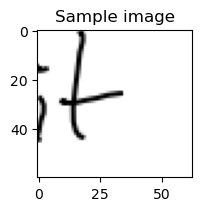

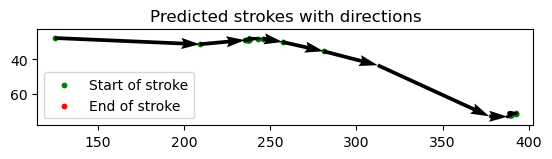

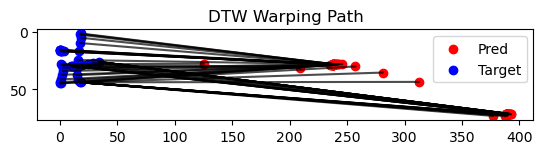

Epoch 50:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 175.3036
   Batch: 100  | Width: 46  | Loss: 243.4741
   Batch: 200  | Width: 56  | Loss: 256.0964
   Batch: 300  | Width: 64  | Loss: 249.5482
   Batch: 400  | Width: 72  | Loss: 213.2404
   Batch: 500  | Width: 78  | Loss: 274.2073
   Batch: 600  | Width: 84  | Loss: 230.6455
   Batch: 700  | Width: 90  | Loss: 262.7977
   Batch: 800  | Width: 96  | Loss: 235.6686
   Batch: 900  | Width: 102 | Loss: 282.7410
   Batch: 1000 | Width: 108 | Loss: 283.1573
   Batch: 1100 | Width: 114 | Loss: 337.2981
   Batch: 1200 | Width: 120 | Loss: 329.5281
   Batch: 1300 | Width: 126 | Loss: 383.7194
   Batch: 1400 | Width: 134 | Loss: 377.9025
   Batch: 1500 | Width: 140 | Loss: 317.4228
   Batch: 1600 | Width: 148 | Loss: 383.3977
   Batch: 1700 | Width: 156 | Loss: 372.3590
   Batch: 1800 | Width: 166 | Loss: 419.7503
   Batch: 1900 | Width: 176 | Loss: 364.7023
   Batch: 2000 | Width: 188 | Loss: 448.3628
   Batch: 2100 | Width: 200 | Loss: 416.9991
   Batch: 

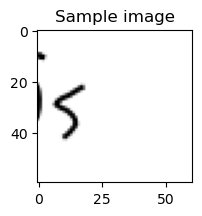

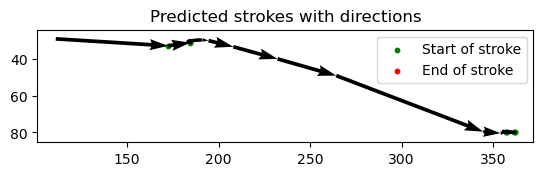

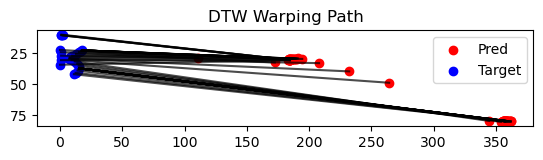

Epoch 51:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 155.8698
   Batch: 100  | Width: 46  | Loss: 243.8364
   Batch: 200  | Width: 56  | Loss: 266.4367
   Batch: 300  | Width: 64  | Loss: 251.5017
   Batch: 400  | Width: 72  | Loss: 227.3896
   Batch: 500  | Width: 78  | Loss: 258.2969
   Batch: 600  | Width: 84  | Loss: 228.7636
   Batch: 700  | Width: 90  | Loss: 256.0649
   Batch: 800  | Width: 96  | Loss: 236.2983
   Batch: 900  | Width: 102 | Loss: 304.0989
   Batch: 1000 | Width: 108 | Loss: 276.3390
   Batch: 1100 | Width: 114 | Loss: 317.6659
   Batch: 1200 | Width: 120 | Loss: 279.5120
   Batch: 1300 | Width: 126 | Loss: 373.3549
   Batch: 1400 | Width: 134 | Loss: 367.5934
   Batch: 1500 | Width: 140 | Loss: 294.9572
   Batch: 1600 | Width: 148 | Loss: 406.0695
   Batch: 1700 | Width: 156 | Loss: 348.0037
   Batch: 1800 | Width: 166 | Loss: 442.5596
   Batch: 1900 | Width: 176 | Loss: 344.4598
   Batch: 2000 | Width: 188 | Loss: 459.7790
   Batch: 2100 | Width: 200 | Loss: 377.0100
   Batch: 

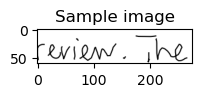

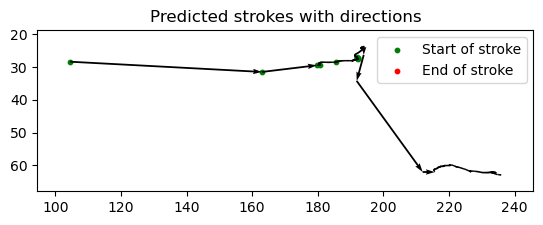

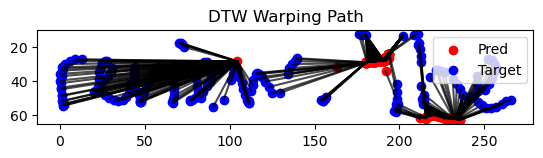

Epoch 52:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 180.1736
   Batch: 100  | Width: 46  | Loss: 241.6381
   Batch: 200  | Width: 56  | Loss: 253.9354
   Batch: 300  | Width: 64  | Loss: 262.6934
   Batch: 400  | Width: 72  | Loss: 218.9043
   Batch: 500  | Width: 78  | Loss: 249.8054
   Batch: 600  | Width: 84  | Loss: 214.0350
   Batch: 700  | Width: 90  | Loss: 248.5686
   Batch: 800  | Width: 96  | Loss: 229.5746
   Batch: 900  | Width: 102 | Loss: 299.8448
   Batch: 1000 | Width: 108 | Loss: 281.4917
   Batch: 1100 | Width: 114 | Loss: 330.0623
   Batch: 1200 | Width: 120 | Loss: 320.2775
   Batch: 1300 | Width: 126 | Loss: 354.8911
   Batch: 1400 | Width: 134 | Loss: 362.3899
   Batch: 1500 | Width: 140 | Loss: 316.7735
   Batch: 1600 | Width: 148 | Loss: 379.4705
   Batch: 1700 | Width: 156 | Loss: 341.5419
   Batch: 1800 | Width: 166 | Loss: 428.0541
   Batch: 1900 | Width: 176 | Loss: 357.1993
   Batch: 2000 | Width: 188 | Loss: 468.3694
   Batch: 2100 | Width: 200 | Loss: 427.5239
   Batch: 

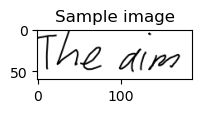

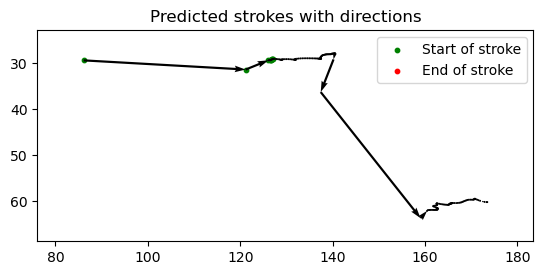

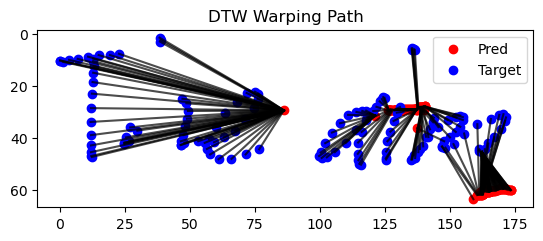

Epoch 53:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 170.2436
   Batch: 100  | Width: 46  | Loss: 246.1059
   Batch: 200  | Width: 56  | Loss: 237.4410
   Batch: 300  | Width: 64  | Loss: 263.4310
   Batch: 400  | Width: 72  | Loss: 212.3282
   Batch: 500  | Width: 78  | Loss: 255.6486
   Batch: 600  | Width: 84  | Loss: 234.8844
   Batch: 700  | Width: 90  | Loss: 270.3040
   Batch: 800  | Width: 96  | Loss: 231.9279
   Batch: 900  | Width: 102 | Loss: 304.3292
   Batch: 1000 | Width: 108 | Loss: 307.4128
   Batch: 1100 | Width: 114 | Loss: 307.5828
   Batch: 1200 | Width: 120 | Loss: 338.5713
   Batch: 1300 | Width: 126 | Loss: 370.7754
   Batch: 1400 | Width: 134 | Loss: 334.1989
   Batch: 1500 | Width: 140 | Loss: 314.1741
   Batch: 1600 | Width: 148 | Loss: 370.3637
   Batch: 1700 | Width: 156 | Loss: 343.9626
   Batch: 1800 | Width: 166 | Loss: 424.6455
   Batch: 1900 | Width: 176 | Loss: 340.8925
   Batch: 2000 | Width: 188 | Loss: 449.9557
   Batch: 2100 | Width: 200 | Loss: 438.4487
   Batch: 

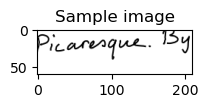

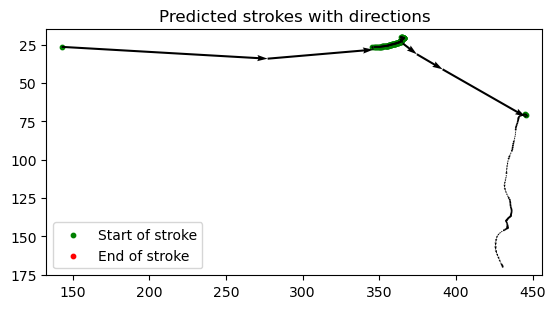

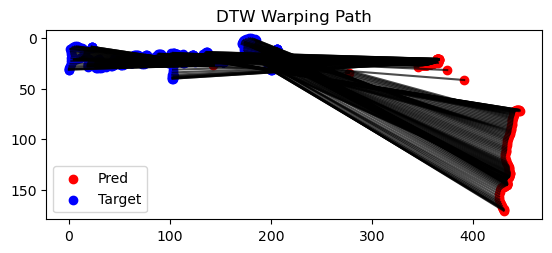

Epoch 54:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 160.9533
   Batch: 100  | Width: 46  | Loss: 245.5234
   Batch: 200  | Width: 56  | Loss: 253.6287
   Batch: 300  | Width: 64  | Loss: 244.2806
   Batch: 400  | Width: 72  | Loss: 210.9109
   Batch: 500  | Width: 78  | Loss: 237.7363
   Batch: 600  | Width: 84  | Loss: 228.5345
   Batch: 700  | Width: 90  | Loss: 260.4569
   Batch: 800  | Width: 96  | Loss: 234.6755
   Batch: 900  | Width: 102 | Loss: 308.0517
   Batch: 1000 | Width: 108 | Loss: 300.6702
   Batch: 1100 | Width: 114 | Loss: 324.3586
   Batch: 1200 | Width: 120 | Loss: 326.5476
   Batch: 1300 | Width: 126 | Loss: 387.2122
   Batch: 1400 | Width: 134 | Loss: 361.9397
   Batch: 1500 | Width: 140 | Loss: 301.1733
   Batch: 1600 | Width: 148 | Loss: 353.4842
   Batch: 1700 | Width: 156 | Loss: 339.3097
   Batch: 1800 | Width: 166 | Loss: 410.4258
   Batch: 1900 | Width: 176 | Loss: 337.3856
   Batch: 2000 | Width: 188 | Loss: 447.4096
   Batch: 2100 | Width: 200 | Loss: 393.1824
   Batch: 

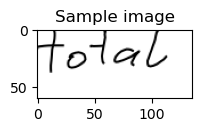

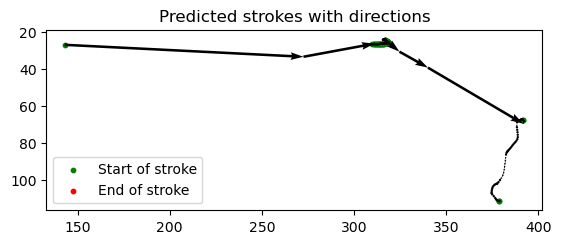

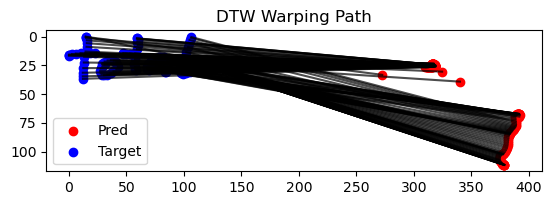

Epoch 55:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 166.8960
   Batch: 100  | Width: 46  | Loss: 242.5530
   Batch: 200  | Width: 56  | Loss: 241.0591
   Batch: 300  | Width: 64  | Loss: 262.4920
   Batch: 400  | Width: 72  | Loss: 219.7190
   Batch: 500  | Width: 78  | Loss: 259.2173
   Batch: 600  | Width: 84  | Loss: 227.6917
   Batch: 700  | Width: 90  | Loss: 270.0884
   Batch: 800  | Width: 96  | Loss: 241.3275
   Batch: 900  | Width: 102 | Loss: 289.3661
   Batch: 1000 | Width: 108 | Loss: 290.0557
   Batch: 1100 | Width: 114 | Loss: 297.2108
   Batch: 1200 | Width: 120 | Loss: 329.9697
   Batch: 1300 | Width: 126 | Loss: 381.7866
   Batch: 1400 | Width: 134 | Loss: 365.5779
   Batch: 1500 | Width: 140 | Loss: 319.3653
   Batch: 1600 | Width: 148 | Loss: 370.1562
   Batch: 1700 | Width: 156 | Loss: 340.7989
   Batch: 1800 | Width: 166 | Loss: 414.8333
   Batch: 1900 | Width: 176 | Loss: 332.0619
   Batch: 2000 | Width: 188 | Loss: 461.7447
   Batch: 2100 | Width: 200 | Loss: 395.4398
   Batch: 

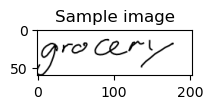

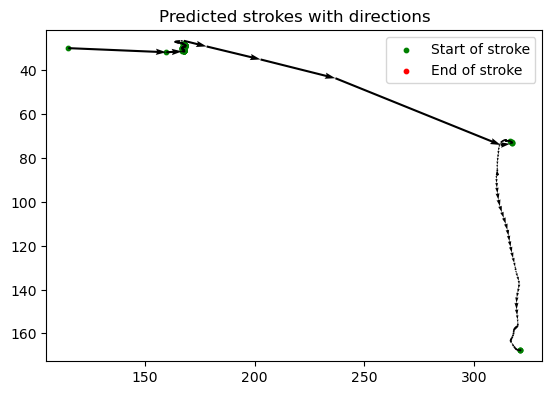

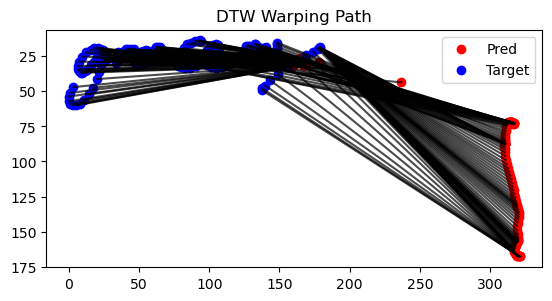

Epoch 56:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 159.2891
   Batch: 100  | Width: 46  | Loss: 246.0101
   Batch: 200  | Width: 56  | Loss: 258.5231
   Batch: 300  | Width: 64  | Loss: 255.8765
   Batch: 400  | Width: 72  | Loss: 212.1362
   Batch: 500  | Width: 78  | Loss: 249.0641
   Batch: 600  | Width: 84  | Loss: 236.4074
   Batch: 700  | Width: 90  | Loss: 251.1179
   Batch: 800  | Width: 96  | Loss: 234.7775
   Batch: 900  | Width: 102 | Loss: 292.2413
   Batch: 1000 | Width: 108 | Loss: 281.3014
   Batch: 1100 | Width: 114 | Loss: 316.3869
   Batch: 1200 | Width: 120 | Loss: 309.0921
   Batch: 1300 | Width: 126 | Loss: 380.0560
   Batch: 1400 | Width: 134 | Loss: 362.1432
   Batch: 1500 | Width: 140 | Loss: 306.2519
   Batch: 1600 | Width: 148 | Loss: 371.7307
   Batch: 1700 | Width: 156 | Loss: 362.7334
   Batch: 1800 | Width: 166 | Loss: 411.4534
   Batch: 1900 | Width: 176 | Loss: 350.7717
   Batch: 2000 | Width: 188 | Loss: 425.5148
   Batch: 2100 | Width: 200 | Loss: 378.6897
   Batch: 

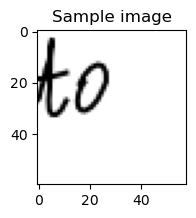

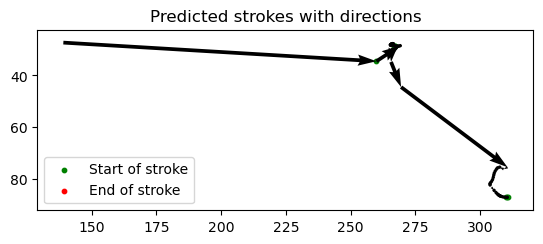

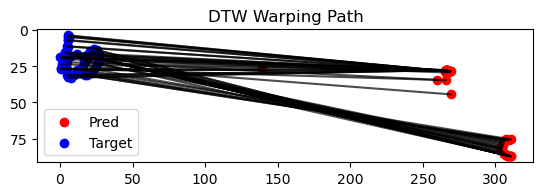

Epoch 57:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 153.3250
   Batch: 100  | Width: 46  | Loss: 245.3078
   Batch: 200  | Width: 56  | Loss: 254.6628
   Batch: 300  | Width: 64  | Loss: 251.8008
   Batch: 400  | Width: 72  | Loss: 210.6434
   Batch: 500  | Width: 78  | Loss: 241.6114
   Batch: 600  | Width: 84  | Loss: 233.0770
   Batch: 700  | Width: 90  | Loss: 261.5548
   Batch: 800  | Width: 96  | Loss: 228.2530
   Batch: 900  | Width: 102 | Loss: 290.2547
   Batch: 1000 | Width: 108 | Loss: 313.2830
   Batch: 1100 | Width: 114 | Loss: 304.6131
   Batch: 1200 | Width: 120 | Loss: 352.4849
   Batch: 1300 | Width: 126 | Loss: 376.1625
   Batch: 1400 | Width: 134 | Loss: 372.7603
   Batch: 1500 | Width: 140 | Loss: 298.0411
   Batch: 1600 | Width: 148 | Loss: 359.6705
   Batch: 1700 | Width: 156 | Loss: 337.2129
   Batch: 1800 | Width: 166 | Loss: 440.5682
   Batch: 1900 | Width: 176 | Loss: 358.8243
   Batch: 2000 | Width: 188 | Loss: 518.3444
   Batch: 2100 | Width: 200 | Loss: 376.2947
   Batch: 

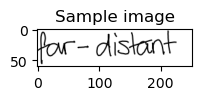

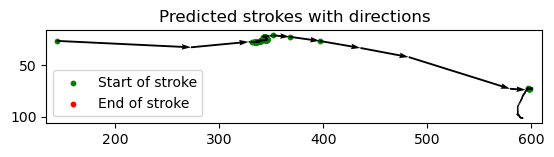

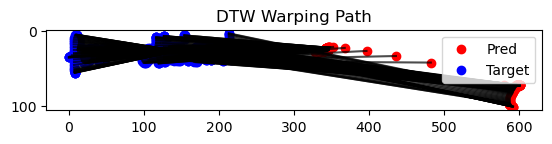

Epoch 58:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 171.5898
   Batch: 100  | Width: 46  | Loss: 246.8477
   Batch: 200  | Width: 56  | Loss: 250.6589
   Batch: 300  | Width: 64  | Loss: 237.4823
   Batch: 400  | Width: 72  | Loss: 234.1588
   Batch: 500  | Width: 78  | Loss: 252.3623
   Batch: 600  | Width: 84  | Loss: 225.7362
   Batch: 700  | Width: 90  | Loss: 257.9915
   Batch: 800  | Width: 96  | Loss: 235.1874
   Batch: 900  | Width: 102 | Loss: 314.8025
   Batch: 1000 | Width: 108 | Loss: 269.0024
   Batch: 1100 | Width: 114 | Loss: 324.4646
   Batch: 1200 | Width: 120 | Loss: 322.7843
   Batch: 1300 | Width: 126 | Loss: 367.3485
   Batch: 1400 | Width: 134 | Loss: 369.8227
   Batch: 1500 | Width: 140 | Loss: 306.4817
   Batch: 1600 | Width: 148 | Loss: 363.3612
   Batch: 1700 | Width: 156 | Loss: 361.1346
   Batch: 1800 | Width: 166 | Loss: 425.8123
   Batch: 1900 | Width: 176 | Loss: 359.7126
   Batch: 2000 | Width: 188 | Loss: 453.7253
   Batch: 2100 | Width: 200 | Loss: 418.4771
   Batch: 

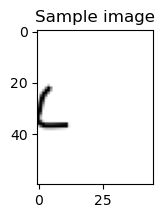

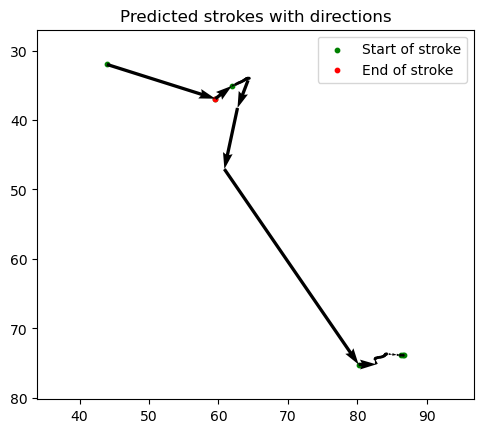

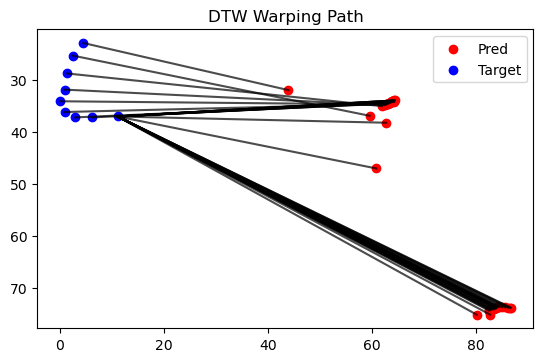

Epoch 59:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 164.1009
   Batch: 100  | Width: 46  | Loss: 242.9481
   Batch: 200  | Width: 56  | Loss: 257.0247
   Batch: 300  | Width: 64  | Loss: 264.5957
   Batch: 400  | Width: 72  | Loss: 225.2506
   Batch: 500  | Width: 78  | Loss: 248.6932
   Batch: 600  | Width: 84  | Loss: 224.4997
   Batch: 700  | Width: 90  | Loss: 253.8616
   Batch: 800  | Width: 96  | Loss: 236.8199
   Batch: 900  | Width: 102 | Loss: 312.8688
   Batch: 1000 | Width: 108 | Loss: 294.6298
   Batch: 1100 | Width: 114 | Loss: 310.8561
   Batch: 1200 | Width: 120 | Loss: 319.6172
   Batch: 1300 | Width: 126 | Loss: 371.1971
   Batch: 1400 | Width: 134 | Loss: 369.5110
   Batch: 1500 | Width: 140 | Loss: 307.9100
   Batch: 1600 | Width: 148 | Loss: 346.7214
   Batch: 1700 | Width: 156 | Loss: 352.6770
   Batch: 1800 | Width: 166 | Loss: 400.6438
   Batch: 1900 | Width: 176 | Loss: 386.4121
   Batch: 2000 | Width: 188 | Loss: 456.2245
   Batch: 2100 | Width: 200 | Loss: 399.7781
   Batch: 

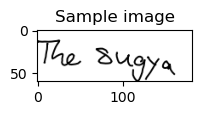

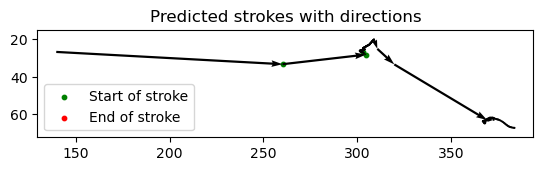

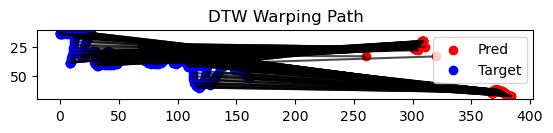

Epoch 60:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 151.2133
   Batch: 100  | Width: 46  | Loss: 246.3188
   Batch: 200  | Width: 56  | Loss: 264.8115
   Batch: 300  | Width: 64  | Loss: 259.5450
   Batch: 400  | Width: 72  | Loss: 212.2663
   Batch: 500  | Width: 78  | Loss: 253.9291
   Batch: 600  | Width: 84  | Loss: 231.7106
   Batch: 700  | Width: 90  | Loss: 248.5674
   Batch: 800  | Width: 96  | Loss: 233.1092
   Batch: 900  | Width: 102 | Loss: 299.6096
   Batch: 1000 | Width: 108 | Loss: 288.7203
   Batch: 1100 | Width: 114 | Loss: 280.6341
   Batch: 1200 | Width: 120 | Loss: 324.3422
   Batch: 1300 | Width: 126 | Loss: 371.0800
   Batch: 1400 | Width: 134 | Loss: 375.1509
   Batch: 1500 | Width: 140 | Loss: 307.2104
   Batch: 1600 | Width: 148 | Loss: 355.6720
   Batch: 1700 | Width: 156 | Loss: 356.4701
   Batch: 1800 | Width: 166 | Loss: 405.3739
   Batch: 1900 | Width: 176 | Loss: 327.6880
   Batch: 2000 | Width: 188 | Loss: 491.1210
   Batch: 2100 | Width: 200 | Loss: 412.0649
   Batch: 

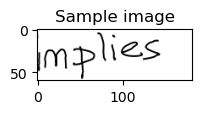

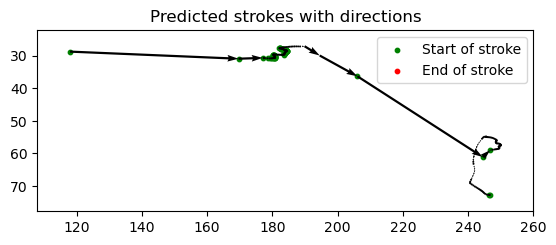

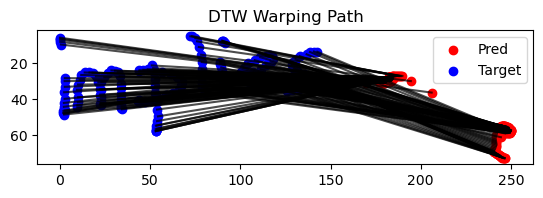

Epoch 61:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 174.2204
   Batch: 100  | Width: 46  | Loss: 241.6883
   Batch: 200  | Width: 56  | Loss: 261.6607
   Batch: 300  | Width: 64  | Loss: 236.9788
   Batch: 400  | Width: 72  | Loss: 215.8650
   Batch: 500  | Width: 78  | Loss: 255.0801
   Batch: 600  | Width: 84  | Loss: 226.1385
   Batch: 700  | Width: 90  | Loss: 261.5818
   Batch: 800  | Width: 96  | Loss: 241.3737
   Batch: 900  | Width: 102 | Loss: 297.0548
   Batch: 1000 | Width: 108 | Loss: 325.2862
   Batch: 1100 | Width: 114 | Loss: 299.9637
   Batch: 1200 | Width: 120 | Loss: 313.0011
   Batch: 1300 | Width: 126 | Loss: 384.8625
   Batch: 1400 | Width: 134 | Loss: 363.4026
   Batch: 1500 | Width: 140 | Loss: 307.4337
   Batch: 1600 | Width: 148 | Loss: 372.3013
   Batch: 1700 | Width: 156 | Loss: 360.2034
   Batch: 1800 | Width: 166 | Loss: 407.3716
   Batch: 1900 | Width: 176 | Loss: 360.1594
   Batch: 2000 | Width: 188 | Loss: 456.1794
   Batch: 2100 | Width: 200 | Loss: 391.0788
   Batch: 

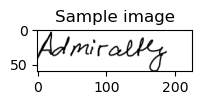

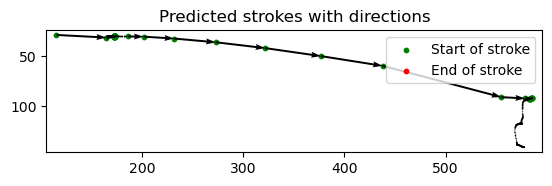

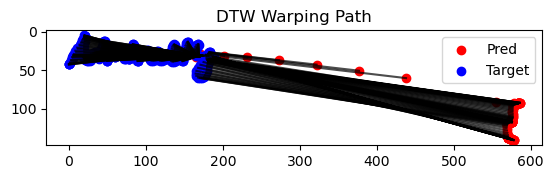

Epoch 62:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 174.2860
   Batch: 100  | Width: 46  | Loss: 238.9526
   Batch: 200  | Width: 56  | Loss: 256.1898
   Batch: 300  | Width: 64  | Loss: 240.4349
   Batch: 400  | Width: 72  | Loss: 222.3607
   Batch: 500  | Width: 78  | Loss: 235.0795
   Batch: 600  | Width: 84  | Loss: 229.0315
   Batch: 700  | Width: 90  | Loss: 251.2483
   Batch: 800  | Width: 96  | Loss: 230.3519
   Batch: 900  | Width: 102 | Loss: 292.0044
   Batch: 1000 | Width: 108 | Loss: 302.8975
   Batch: 1100 | Width: 114 | Loss: 321.5817
   Batch: 1200 | Width: 120 | Loss: 326.9008
   Batch: 1300 | Width: 126 | Loss: 384.6727
   Batch: 1400 | Width: 134 | Loss: 363.2075
   Batch: 1500 | Width: 140 | Loss: 322.0328
   Batch: 1600 | Width: 148 | Loss: 353.2520
   Batch: 1700 | Width: 156 | Loss: 380.2881
   Batch: 1800 | Width: 166 | Loss: 411.1526
   Batch: 1900 | Width: 176 | Loss: 340.1956
   Batch: 2000 | Width: 188 | Loss: 473.3876
   Batch: 2100 | Width: 200 | Loss: 379.1779
   Batch: 

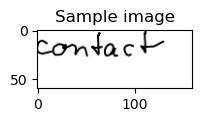

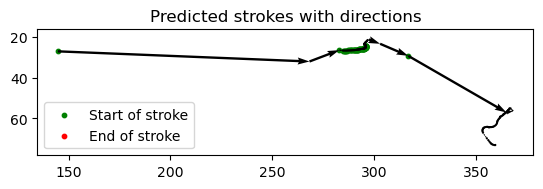

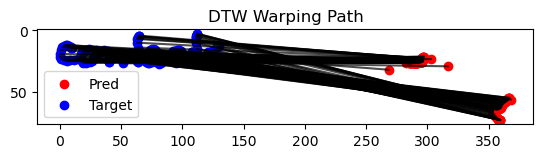

Epoch 63:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 165.2823
   Batch: 100  | Width: 46  | Loss: 243.3526
   Batch: 200  | Width: 56  | Loss: 266.8786
   Batch: 300  | Width: 64  | Loss: 260.1380
   Batch: 400  | Width: 72  | Loss: 214.6282
   Batch: 500  | Width: 78  | Loss: 257.5252
   Batch: 600  | Width: 84  | Loss: 216.4499
   Batch: 700  | Width: 90  | Loss: 258.0063
   Batch: 800  | Width: 96  | Loss: 232.4757
   Batch: 900  | Width: 102 | Loss: 312.1929
   Batch: 1000 | Width: 108 | Loss: 305.6924
   Batch: 1100 | Width: 114 | Loss: 295.6247
   Batch: 1200 | Width: 120 | Loss: 336.1606
   Batch: 1300 | Width: 126 | Loss: 374.3051
   Batch: 1400 | Width: 134 | Loss: 362.0755
   Batch: 1500 | Width: 140 | Loss: 306.5297
   Batch: 1600 | Width: 148 | Loss: 344.7389
   Batch: 1700 | Width: 156 | Loss: 349.3850
   Batch: 1800 | Width: 166 | Loss: 409.6433
   Batch: 1900 | Width: 176 | Loss: 346.1832
   Batch: 2000 | Width: 188 | Loss: 500.6400
   Batch: 2100 | Width: 200 | Loss: 386.9300
   Batch: 

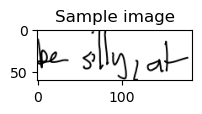

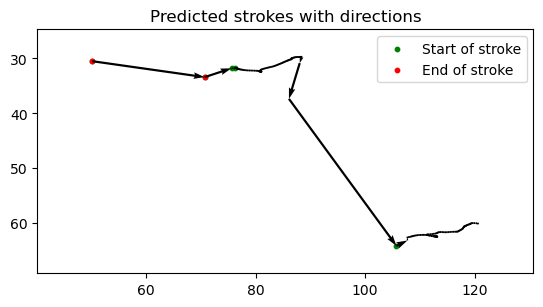

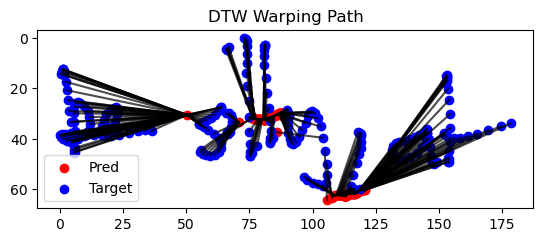

Epoch 64:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 151.5723
   Batch: 100  | Width: 46  | Loss: 241.7323
   Batch: 200  | Width: 56  | Loss: 242.9200
   Batch: 300  | Width: 64  | Loss: 258.4327
   Batch: 400  | Width: 72  | Loss: 207.2975
   Batch: 500  | Width: 78  | Loss: 247.3993
   Batch: 600  | Width: 84  | Loss: 228.2061
   Batch: 700  | Width: 90  | Loss: 244.0578
   Batch: 800  | Width: 96  | Loss: 222.8124
   Batch: 900  | Width: 102 | Loss: 322.1605
   Batch: 1000 | Width: 108 | Loss: 295.9719
   Batch: 1100 | Width: 114 | Loss: 326.5054
   Batch: 1200 | Width: 120 | Loss: 313.8111
   Batch: 1300 | Width: 126 | Loss: 355.5379
   Batch: 1400 | Width: 134 | Loss: 383.8094
   Batch: 1500 | Width: 140 | Loss: 316.8631
   Batch: 1600 | Width: 148 | Loss: 360.8757
   Batch: 1700 | Width: 156 | Loss: 344.5605
   Batch: 1800 | Width: 166 | Loss: 413.9717
   Batch: 1900 | Width: 176 | Loss: 343.7514
   Batch: 2000 | Width: 188 | Loss: 437.2348
   Batch: 2100 | Width: 200 | Loss: 400.5345
   Batch: 

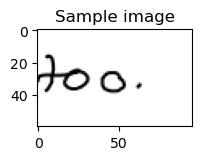

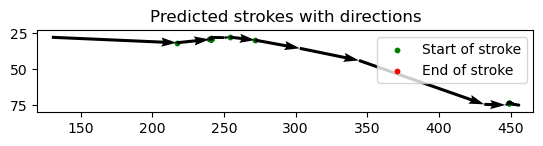

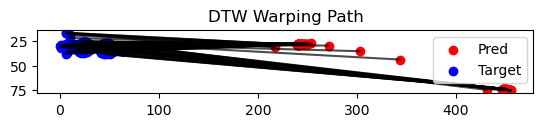

Epoch 65:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 162.3498
   Batch: 100  | Width: 46  | Loss: 248.0032
   Batch: 200  | Width: 56  | Loss: 254.5901
   Batch: 300  | Width: 64  | Loss: 247.0917
   Batch: 400  | Width: 72  | Loss: 201.3041
   Batch: 500  | Width: 78  | Loss: 255.6973
   Batch: 600  | Width: 84  | Loss: 232.4252
   Batch: 700  | Width: 90  | Loss: 260.1692
   Batch: 800  | Width: 96  | Loss: 242.4861
   Batch: 900  | Width: 102 | Loss: 293.9295
   Batch: 1000 | Width: 108 | Loss: 292.2133
   Batch: 1100 | Width: 114 | Loss: 312.4550
   Batch: 1200 | Width: 120 | Loss: 320.0073
   Batch: 1300 | Width: 126 | Loss: 385.1085
   Batch: 1400 | Width: 134 | Loss: 362.5063
   Batch: 1500 | Width: 140 | Loss: 314.4294
   Batch: 1600 | Width: 148 | Loss: 362.0172
   Batch: 1700 | Width: 156 | Loss: 357.5277
   Batch: 1800 | Width: 166 | Loss: 435.6052
   Batch: 1900 | Width: 176 | Loss: 353.0372
   Batch: 2000 | Width: 188 | Loss: 463.3757
   Batch: 2100 | Width: 200 | Loss: 388.1762
   Batch: 

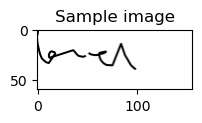

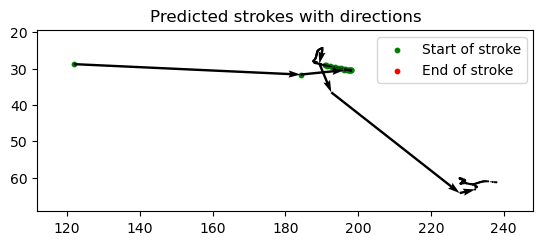

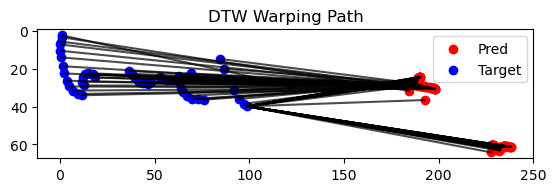

Epoch 66:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 161.8203
   Batch: 100  | Width: 46  | Loss: 242.1759
   Batch: 200  | Width: 56  | Loss: 258.8165
   Batch: 300  | Width: 64  | Loss: 241.9519
   Batch: 400  | Width: 72  | Loss: 206.2305
   Batch: 500  | Width: 78  | Loss: 244.3837
   Batch: 600  | Width: 84  | Loss: 217.9863
   Batch: 700  | Width: 90  | Loss: 250.6679
   Batch: 800  | Width: 96  | Loss: 229.3993
   Batch: 900  | Width: 102 | Loss: 302.9263
   Batch: 1000 | Width: 108 | Loss: 282.9507
   Batch: 1100 | Width: 114 | Loss: 315.3102
   Batch: 1200 | Width: 120 | Loss: 324.3420
   Batch: 1300 | Width: 126 | Loss: 367.6719
   Batch: 1400 | Width: 134 | Loss: 365.1060
   Batch: 1500 | Width: 140 | Loss: 325.0661
   Batch: 1600 | Width: 148 | Loss: 391.2021
   Batch: 1700 | Width: 156 | Loss: 345.0094
   Batch: 1800 | Width: 166 | Loss: 421.4256
   Batch: 1900 | Width: 176 | Loss: 330.4769
   Batch: 2000 | Width: 188 | Loss: 489.5164
   Batch: 2100 | Width: 200 | Loss: 384.2341
   Batch: 

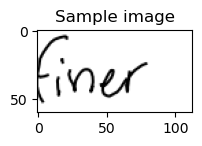

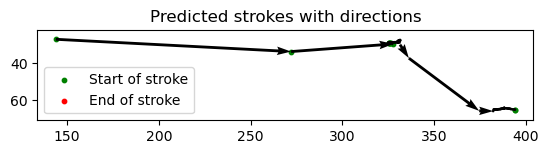

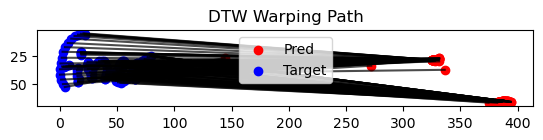

Epoch 67:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 161.5134
   Batch: 100  | Width: 46  | Loss: 248.4977
   Batch: 200  | Width: 56  | Loss: 265.1028
   Batch: 300  | Width: 64  | Loss: 242.8391
   Batch: 400  | Width: 72  | Loss: 214.2103
   Batch: 500  | Width: 78  | Loss: 251.9490
   Batch: 600  | Width: 84  | Loss: 227.9867
   Batch: 700  | Width: 90  | Loss: 255.7689
   Batch: 800  | Width: 96  | Loss: 219.0517
   Batch: 900  | Width: 102 | Loss: 288.3112
   Batch: 1000 | Width: 108 | Loss: 295.0333
   Batch: 1100 | Width: 114 | Loss: 322.0018
   Batch: 1200 | Width: 120 | Loss: 321.6293
   Batch: 1300 | Width: 126 | Loss: 361.3220
   Batch: 1400 | Width: 134 | Loss: 363.9507
   Batch: 1500 | Width: 140 | Loss: 300.2100
   Batch: 1600 | Width: 148 | Loss: 355.9465
   Batch: 1700 | Width: 156 | Loss: 347.6186
   Batch: 1800 | Width: 166 | Loss: 419.8977
   Batch: 1900 | Width: 176 | Loss: 344.4260
   Batch: 2000 | Width: 188 | Loss: 493.3840
   Batch: 2100 | Width: 200 | Loss: 399.3377
   Batch: 

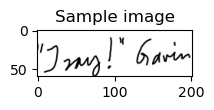

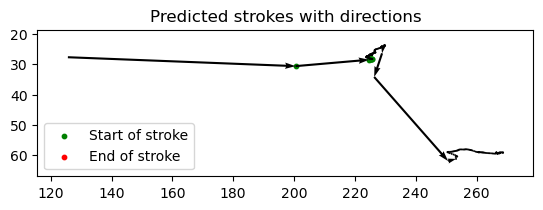

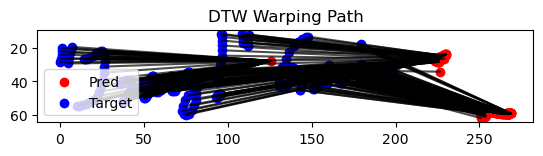

Epoch 68:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 176.9969
   Batch: 100  | Width: 46  | Loss: 235.0264
   Batch: 200  | Width: 56  | Loss: 250.9855
   Batch: 300  | Width: 64  | Loss: 248.6426
   Batch: 400  | Width: 72  | Loss: 221.8024
   Batch: 500  | Width: 78  | Loss: 256.0617
   Batch: 600  | Width: 84  | Loss: 219.4883
   Batch: 700  | Width: 90  | Loss: 259.4053
   Batch: 800  | Width: 96  | Loss: 227.4370
   Batch: 900  | Width: 102 | Loss: 292.9910
   Batch: 1000 | Width: 108 | Loss: 281.9862
   Batch: 1100 | Width: 114 | Loss: 308.3407
   Batch: 1200 | Width: 120 | Loss: 312.6677
   Batch: 1300 | Width: 126 | Loss: 373.2785
   Batch: 1400 | Width: 134 | Loss: 339.5662
   Batch: 1500 | Width: 140 | Loss: 314.6243
   Batch: 1600 | Width: 148 | Loss: 398.8559
   Batch: 1700 | Width: 156 | Loss: 348.5682
   Batch: 1800 | Width: 166 | Loss: 431.4822
   Batch: 1900 | Width: 176 | Loss: 359.1422
   Batch: 2000 | Width: 188 | Loss: 440.8451
   Batch: 2100 | Width: 200 | Loss: 389.1149
   Batch: 

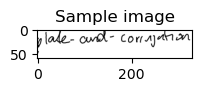

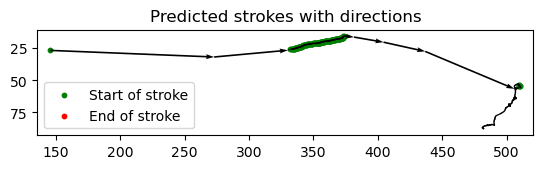

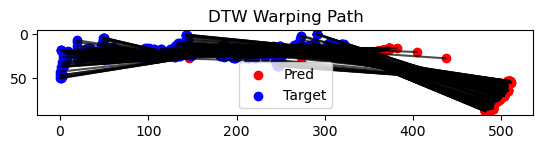

Epoch 69:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 157.5705
   Batch: 100  | Width: 46  | Loss: 243.8177
   Batch: 200  | Width: 56  | Loss: 253.8587
   Batch: 300  | Width: 64  | Loss: 232.3370
   Batch: 400  | Width: 72  | Loss: 218.6759
   Batch: 500  | Width: 78  | Loss: 238.9038
   Batch: 600  | Width: 84  | Loss: 236.3247
   Batch: 700  | Width: 90  | Loss: 248.9735
   Batch: 800  | Width: 96  | Loss: 218.9365
   Batch: 900  | Width: 102 | Loss: 296.5344
   Batch: 1000 | Width: 108 | Loss: 285.8836
   Batch: 1100 | Width: 114 | Loss: 282.2981
   Batch: 1200 | Width: 120 | Loss: 349.3325
   Batch: 1300 | Width: 126 | Loss: 375.8924
   Batch: 1400 | Width: 134 | Loss: 372.7161
   Batch: 1500 | Width: 140 | Loss: 301.9135
   Batch: 1600 | Width: 148 | Loss: 355.5448
   Batch: 1700 | Width: 156 | Loss: 364.8010
   Batch: 1800 | Width: 166 | Loss: 431.6943
   Batch: 1900 | Width: 176 | Loss: 330.9675
   Batch: 2000 | Width: 188 | Loss: 457.0972
   Batch: 2100 | Width: 200 | Loss: 372.6535
   Batch: 

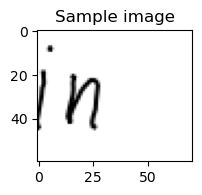

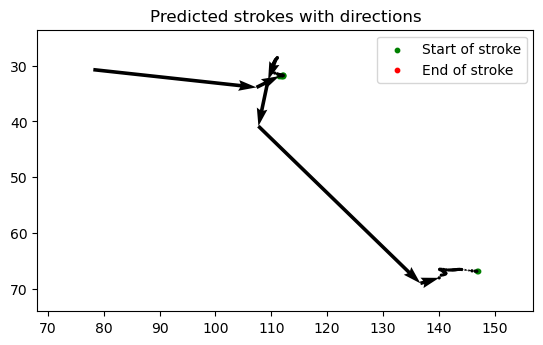

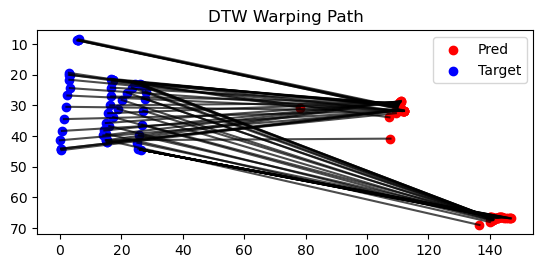

Epoch 70:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 154.4739
   Batch: 100  | Width: 46  | Loss: 234.1722
   Batch: 200  | Width: 56  | Loss: 254.4418
   Batch: 300  | Width: 64  | Loss: 259.8553
   Batch: 400  | Width: 72  | Loss: 209.0093
   Batch: 500  | Width: 78  | Loss: 235.1688
   Batch: 600  | Width: 84  | Loss: 228.2383
   Batch: 700  | Width: 90  | Loss: 251.4217
   Batch: 800  | Width: 96  | Loss: 225.8441
   Batch: 900  | Width: 102 | Loss: 296.4610
   Batch: 1000 | Width: 108 | Loss: 312.4394
   Batch: 1100 | Width: 114 | Loss: 321.2566
   Batch: 1200 | Width: 120 | Loss: 322.7487
   Batch: 1300 | Width: 126 | Loss: 360.0023
   Batch: 1400 | Width: 134 | Loss: 368.2893
   Batch: 1500 | Width: 140 | Loss: 298.0845
   Batch: 1600 | Width: 148 | Loss: 366.5053
   Batch: 1700 | Width: 156 | Loss: 362.7791
   Batch: 1800 | Width: 166 | Loss: 430.2468
   Batch: 1900 | Width: 176 | Loss: 347.1080
   Batch: 2000 | Width: 188 | Loss: 466.3733
   Batch: 2100 | Width: 200 | Loss: 395.8599
   Batch: 

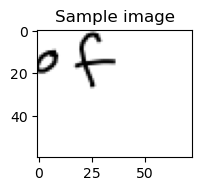

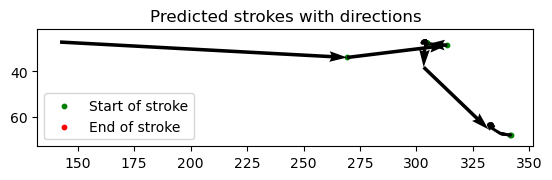

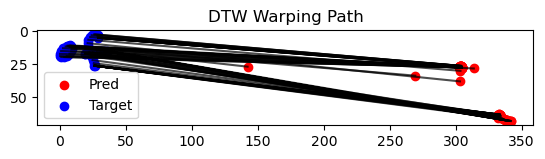

Epoch 71:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 149.4344
   Batch: 100  | Width: 46  | Loss: 243.1712
   Batch: 200  | Width: 56  | Loss: 266.7540
   Batch: 300  | Width: 64  | Loss: 252.6790
   Batch: 400  | Width: 72  | Loss: 210.7908
   Batch: 500  | Width: 78  | Loss: 231.9309
   Batch: 600  | Width: 84  | Loss: 224.9833
   Batch: 700  | Width: 90  | Loss: 275.5149
   Batch: 800  | Width: 96  | Loss: 233.1199
   Batch: 900  | Width: 102 | Loss: 286.5555
   Batch: 1000 | Width: 108 | Loss: 300.7623
   Batch: 1100 | Width: 114 | Loss: 321.4238
   Batch: 1200 | Width: 120 | Loss: 336.0788
   Batch: 1300 | Width: 126 | Loss: 365.3588
   Batch: 1400 | Width: 134 | Loss: 345.6038
   Batch: 1500 | Width: 140 | Loss: 311.3609
   Batch: 1600 | Width: 148 | Loss: 367.8963
   Batch: 1700 | Width: 156 | Loss: 353.2157
   Batch: 1800 | Width: 166 | Loss: 429.0193
   Batch: 1900 | Width: 176 | Loss: 339.9933
   Batch: 2000 | Width: 188 | Loss: 455.3908
   Batch: 2100 | Width: 200 | Loss: 379.8164
   Batch: 

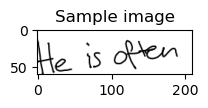

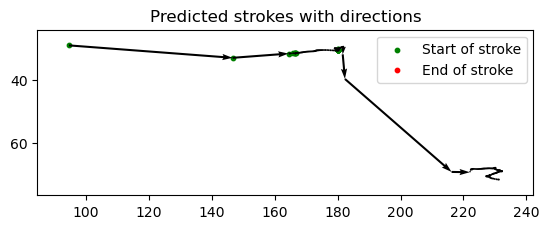

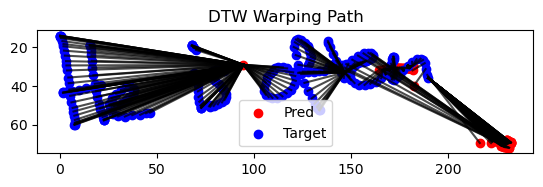

Epoch 72:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 147.1477
   Batch: 100  | Width: 46  | Loss: 237.0552
   Batch: 200  | Width: 56  | Loss: 260.9629
   Batch: 300  | Width: 64  | Loss: 262.8371
   Batch: 400  | Width: 72  | Loss: 208.7601
   Batch: 500  | Width: 78  | Loss: 237.6192
   Batch: 600  | Width: 84  | Loss: 225.7247
   Batch: 700  | Width: 90  | Loss: 260.4446
   Batch: 800  | Width: 96  | Loss: 225.3117
   Batch: 900  | Width: 102 | Loss: 289.7181
   Batch: 1000 | Width: 108 | Loss: 312.0954
   Batch: 1100 | Width: 114 | Loss: 318.3141
   Batch: 1200 | Width: 120 | Loss: 333.9719
   Batch: 1300 | Width: 126 | Loss: 371.0579
   Batch: 1400 | Width: 134 | Loss: 359.7959
   Batch: 1500 | Width: 140 | Loss: 310.0973
   Batch: 1600 | Width: 148 | Loss: 361.3293
   Batch: 1700 | Width: 156 | Loss: 346.9519
   Batch: 1800 | Width: 166 | Loss: 411.6846
   Batch: 1900 | Width: 176 | Loss: 348.7203
   Batch: 2000 | Width: 188 | Loss: 448.6484
   Batch: 2100 | Width: 200 | Loss: 381.6653
   Batch: 

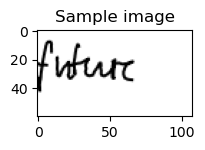

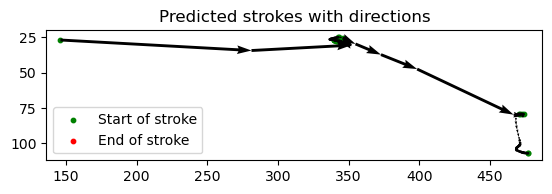

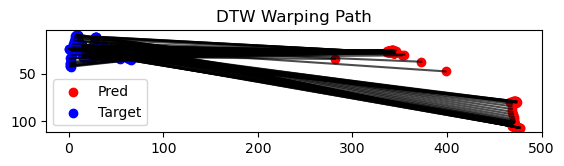

Epoch 73:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 153.7007
   Batch: 100  | Width: 46  | Loss: 237.1815
   Batch: 200  | Width: 56  | Loss: 258.4875
   Batch: 300  | Width: 64  | Loss: 242.0595
   Batch: 400  | Width: 72  | Loss: 206.9793
   Batch: 500  | Width: 78  | Loss: 248.0340
   Batch: 600  | Width: 84  | Loss: 240.9039
   Batch: 700  | Width: 90  | Loss: 249.0605
   Batch: 800  | Width: 96  | Loss: 234.1322
   Batch: 900  | Width: 102 | Loss: 305.4544
   Batch: 1000 | Width: 108 | Loss: 295.9063
   Batch: 1100 | Width: 114 | Loss: 310.8280
   Batch: 1200 | Width: 120 | Loss: 321.8142
   Batch: 1300 | Width: 126 | Loss: 357.0726
   Batch: 1400 | Width: 134 | Loss: 337.6924
   Batch: 1500 | Width: 140 | Loss: 315.8542
   Batch: 1600 | Width: 148 | Loss: 388.5439
   Batch: 1700 | Width: 156 | Loss: 352.9225
   Batch: 1800 | Width: 166 | Loss: 421.9631
   Batch: 1900 | Width: 176 | Loss: 344.5353
   Batch: 2000 | Width: 188 | Loss: 457.1914
   Batch: 2100 | Width: 200 | Loss: 399.2621


In [7]:
# Fitting the model
losses = model_fit(model, dataloader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint_interval, plot=100)